In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy.stats as stats
import random
import re
import utilities as ut
import modularised_utils as mut
import networkx as nx

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

sns.set_theme(style="whitegrid")
seed = 23
np.random.seed(seed)

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [125]:
experiment = 'slc'
setting    = 'empirical'

if setting == 'gaussian':
    path = f"data/{experiment}/results"

elif setting == 'empirical':
    path = f"data/{experiment}/results_empirical"

saved_folds = joblib.load(f"data/{experiment}/cv_folds.pkl")

# Load the original data dictionary
all_data      = ut.load_all_data(experiment)

Dll_samples   = all_data['LLmodel']['data']
Dhl_samples   = all_data['HLmodel']['data']
LLmodel       = all_data['LLmodel']
HLmodel       = all_data['HLmodel']
ll_graph      = all_data['LLmodel']['graph']
hl_graph      = all_data['HLmodel']['graph']
T_matrix_gt   = all_data['abstraction_data']['T']
I_ll_relevant = all_data['LLmodel']['intervention_set']
omega         = all_data['abstraction_data']['omega']
ll_var_names  = list(all_data['LLmodel']['graph'].nodes())
hl_var_names  = list(all_data['HLmodel']['graph'].nodes())

Data loaded for 'slc'.


In [126]:
# Load dictionaries containing the results for each optimization method
if setting == 'gaussian':
    diroca_results = joblib.load(f"{path}/diroca_cv_results.pkl")
    gradca_results = joblib.load(f"{path}/gradca_cv_results.pkl")
    baryca_results = joblib.load(f"{path}/baryca_cv_results.pkl")

elif setting == 'empirical':
    diroca_results = joblib.load(f"{path}/diroca_cv_results_empirical.pkl")
    gradca_results = joblib.load(f"{path}/gradca_cv_results_empirical.pkl")
    baryca_results = joblib.load(f"{path}/baryca_cv_results_empirical.pkl")
    abslingam_results = joblib.load(f"{path}/abslingam_cv_results_empirical.pkl")

results_to_evaluate = {}

if setting == 'empirical':
    if abslingam_results:
        first_fold_key = list(abslingam_results.keys())[0]
        for style in abslingam_results[first_fold_key].keys():
            method_name = f"Abs-LiNGAM ({style})"
            new_abslingam_dict = {}
            for fold_key, fold_results in abslingam_results.items():
                if style in fold_results:
                    new_abslingam_dict[fold_key] = {style: fold_results[style]}
            results_to_evaluate[method_name] = new_abslingam_dict
    
    def create_diroca_label(run_id):
        """Parses a run_id and creates a simplified label if epsilon and delta are equal."""
        # Use regular expression to find numbers for epsilon and delta
        matches = re.findall(r'(\d+\.?\d*)', run_id)
        if len(matches) == 2:
            eps, delta = matches
            # If they are the same, use the simplified format
            if eps == delta:
                # Handle integer conversion for clean labels like '1' instead of '1.0'
                val = int(float(eps)) if float(eps).is_integer() else float(eps)
                return f"DIROCA (eps_delta_{val})"
        # Otherwise, or if parsing fails, use the full original name
        return f"DIROCA ({run_id})"

    # Unpack each DIROCA hyperparameter run with the new, clean label
    if diroca_results:
        first_fold_key = list(diroca_results.keys())[0]
        for run_id in diroca_results[first_fold_key].keys():
            method_name = create_diroca_label(run_id) # Use the new helper to create the name
            new_diroca_dict = {}
            for fold_key, fold_results in diroca_results.items():
                if run_id in fold_results:
                    new_diroca_dict[fold_key] = {run_id: fold_results[run_id]}
            results_to_evaluate[method_name] = new_diroca_dict

    results_to_evaluate['GradCA'] = gradca_results
    results_to_evaluate['BARYCA'] = baryca_results

elif setting == 'gaussian':
    results_to_evaluate['GradCA'] = gradca_results
    results_to_evaluate['BARYCA'] = baryca_results

    if diroca_results:
        first_fold_key = list(diroca_results.keys())[0]
        diroca_run_ids = list(diroca_results[first_fold_key].keys())

        # create a separate entry for each DIROCA run
        for run_id in diroca_run_ids:
            method_name = f"DIROCA ({run_id})"
            
            new_diroca_dict = {}
            for fold_key, fold_results in diroca_results.items():
                # For each fold grab the data for the current run_id
                if run_id in fold_results:
                    new_diroca_dict[fold_key] = {run_id: fold_results[run_id]}
            
            results_to_evaluate[method_name] = new_diroca_dict

label_map_gaussian = {
                        'DIROCA (eps_delta_0.111)': 'DiRoCA_star',
                        'DIROCA (eps_delta_1)': 'DIROCA_1',
                        'DIROCA (eps_delta_2)': 'DIROCA_2',
                        'DIROCA (eps_delta_4)': 'DIROCA_4',
                        'DIROCA (eps_delta_8)': 'DIROCA_8',
                        'GradCA': 'GradCA',
                        'BARYCA': 'BARYCA'
                    }

label_map_empirical = {
                        'DIROCA (eps_0.328_delta_0.107)': 'DiRoCA_star',
                        'DIROCA (eps_delta_1)': 'DIROCA_1',
                        'DIROCA (eps_delta_2)': 'DIROCA_2',
                        'DIROCA (eps_delta_4)': 'DIROCA_4',
                        'DIROCA (eps_delta_8)': 'DIROCA_8',
                        'GradCA': 'GradCA',
                        'BARYCA': 'BARYCA',
                        'Abs-LiNGAM (Perfect)': 'Abslin_p',
                        'Abs-LiNGAM (Noisy)': 'Abslin_n'
                    }

if setting == 'empirical':
    results_to_evaluate = {label_map_empirical.get(key, key): value for key, value in results_to_evaluate.items()}

elif setting == 'gaussian':
    results_to_evaluate = {label_map_gaussian.get(key, key): value for key, value in results_to_evaluate.items()}

print("\nMethods available for evaluation:")
for key in results_to_evaluate.keys():
    print(f"  - {key}")


Methods available for evaluation:
  - Abslin_p
  - Abslin_n
  - DIROCA (eps_0.107_delta_0.035)
  - DIROCA_1
  - DIROCA_2
  - DIROCA_4
  - DIROCA_8
  - GradCA
  - BARYCA


In [127]:
def apply_structural_contamination(
    linear_data,
    graph,
    coeffs,
    noise,
    strength,
    scaled=False,
    nonlinear_func=np.sin,
    k=10
):
    """
    Applies structural contamination to SCM data with flexible reuse strategy.

    Args:
        linear_data (np.ndarray): Original SCM output (already includes noise).
        graph (CausalBayesianNetwork): DAG structure.
        coeffs (dict): Edge weights {(parent, child): weight}.
        noise (np.ndarray): Exogenous noise (same shape as linear_data).
        strength (float): Contamination strength s ∈ [0, 1] (can be >1 if unscaled).
        scaled (bool): Whether to interpolate (scaled=True) or add (scaled=False).
        nonlinear_func (callable): Nonlinear function applied to parent values.

    Returns:
        np.ndarray: Contaminated data (n_samples x dim).
    """
    n_samples, dim = linear_data.shape
    topo_order = list(nx.topological_sort(graph))
    var_index = {var: idx for idx, var in enumerate(topo_order)}

    if strength == 0:
        return linear_data.copy()

    contaminated = np.zeros_like(noise)

    for var in topo_order:
        var_idx = var_index[var]
        parents = list(graph.predecessors(var))

        if not parents:
            linear_part = np.zeros(n_samples)
            nonlinear_part = np.zeros(n_samples)
        else:
            parent_indices = [var_index[p] for p in parents]
            parent_vals = contaminated[:, parent_indices]
            weights = np.array([coeffs.get((p, var), 0.0) for p in parents])
            linear_part = parent_vals @ weights
            nonlinear_part = k*nonlinear_func(parent_vals).sum(axis=1)

        if scaled:
            blended = (1 - strength) * linear_part + strength * nonlinear_part
        else:
            blended = linear_part + strength * nonlinear_part

        contaminated[:, var_idx] = blended + noise[:, var_idx]

    return contaminated


In [128]:
def relu_squared(x):
    return np.maximum(0, x)**2

def leaky_relu(x, alpha=0.1):
    return np.where(x > 0, x, alpha * x)

def relu(x):
    return np.maximum(x, 0)

def tanh(x):
    return np.tanh(x)

def exp(x):
    return np.exp(x)

def sin(x):
    return np.sin(x)

def square(x):
    return x**2

In [129]:
contamination_strengths = [1] #np.linspace(0, 1.0, 11)  
num_trials              = 20
nonlinear_func          = tanh
scaled                  = True   
scales                  = [1] #np.linspace(0, 1, 10)

In [130]:
f_spec_records = []
#for strength in tqdm(contamination_strengths, desc="Contamination Strength"):
for k in scales:
    strength = 1
    for trial in range(num_trials):
        for i, fold_info in enumerate(saved_folds):
            for method_name, results_dict in results_to_evaluate.items():
                fold_results = results_dict.get(f'fold_{i}', {})
                for run_key, run_data in fold_results.items():
                    T_learned = run_data['T_matrix']
                    test_indices = run_data['test_indices']

                    errors_per_intervention = []

                    for iota in I_ll_relevant:
                        # Prepare inputs
                        Dll_clean = Dll_samples[iota][test_indices]
                        Dhl_clean = Dhl_samples[omega[iota]][test_indices]

                        noise_ll = LLmodel['noise'][iota][test_indices]
                        noise_hl = HLmodel['noise'][omega[iota]][test_indices]

                        # Apply contamination based on current strategy
                        Dll_cont = apply_structural_contamination(
                            linear_data=Dll_clean,
                            graph=ll_graph,
                            coeffs=LLmodel['coeffs'],
                            noise=noise_ll,
                            strength=strength,
                            scaled=scaled,
                            nonlinear_func=nonlinear_func,
                            k=k
                        )

                        Dhl_cont = apply_structural_contamination(
                            linear_data=Dhl_clean,
                            graph=hl_graph,
                            coeffs=HLmodel['coeffs'],
                            noise=noise_hl,
                            strength=strength,
                            scaled=scaled,
                            nonlinear_func=nonlinear_func,
                            k=k
                        )

                        if setting == 'gaussian':
                            error = ut.calculate_abstraction_error(T_learned, Dll_cont, Dhl_cont)
                        elif setting == 'empirical':
                            error = ut.calculate_empirical_error(T_learned, Dll_cont, Dhl_cont)
                        else:
                            raise ValueError(f"Unknown setting: {setting}")

                        if not np.isnan(error):
                            errors_per_intervention.append(error)

                    avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
                    f_spec_records.append({
                        'method': method_name,
                        'k_value': k,
                        'contamination': strength,
                        'trial': trial,
                        'fold': i,
                        'error': avg_error
                    })

In [131]:
# Compile results into a DataFrame
f_spec_df = pd.DataFrame(f_spec_records)

print("\n--- F-Misspecification Evaluation Complete ---")
print("="*65)
print("Overall Performance (Averaged Across All Nonlinearity Strengths)")
print("="*65)
print(f"{'Method/Run':<35} | {'Mean ± Std'}")
print("="*65)

summary = f_spec_df.groupby('method')['error'].agg(['mean', 'std', 'count'])
summary['sem'] = summary['std']  # You can uncomment next line for CI
# summary['sem'] = summary['std'] / np.sqrt(summary['count'])
summary['ci95'] = summary['sem']  # or 1.96 * sem

for method_name, row in summary.sort_values('mean').iterrows():
    print(f"{method_name:<35} | {row['mean']:.4f} ± {row['ci95']:.4f}")



--- F-Misspecification Evaluation Complete ---
Overall Performance (Averaged Across All Nonlinearity Strengths)
Method/Run                          | Mean ± Std
DIROCA_8                            | 136.9194 ± 0.4484
DIROCA_2                            | 136.9886 ± 0.4196
DIROCA_4                            | 136.9909 ± 0.4194
DIROCA_1                            | 138.8915 ± 0.8385
GradCA                              | 140.0687 ± 0.8747
BARYCA                              | 186.9390 ± 1.3897
Abslin_n                            | 191.7883 ± 1.5665
DIROCA (eps_0.107_delta_0.035)      | 192.7314 ± 1.4356
Abslin_p                            | 195.2346 ± 1.6239


In [124]:
# Paired t-tests for contamination analysis
from scipy.stats import ttest_rel
import warnings
warnings.filterwarnings('ignore')

# Get the best method (lowest mean error)
best_method = summary['mean'].idxmin()
best_mean = summary.loc[best_method, 'mean']

print(f"\nBest method: {best_method} (mean error: {best_mean:.4f})")
print("\nPaired t-tests (best vs others):")
print("="*60)

# Get data for best method
best_data = f_spec_df[f_spec_df['method'] == best_method]['error'].values

# Compare against all other methods
for method in summary.index:
    if method != best_method:
        other_data = f_spec_df[f_spec_df['method'] == method]['error'].values
        
        # Ensure same number of observations for paired test
        min_len = min(len(best_data), len(other_data))
        if min_len > 0:
            t_stat, p_value = ttest_rel(best_data[:min_len], other_data[:min_len])
            other_mean = summary.loc[method, 'mean']
            diff = best_mean - other_mean
            
            print(f"{best_method} vs {method:<30} | p={p_value:.4f} | diff={diff:.4f} | {'Significant' if p_value < 0.05 else 'Not significant'}")
        else:
            print(f"{best_method} vs {method:<30} | No data available")



Best method: DIROCA_4 (mean error: 328.8238)

Paired t-tests (best vs others):
DIROCA_4 vs Abslin_n                       | p=0.0000 | diff=-57.8929 | Significant
DIROCA_4 vs Abslin_p                       | p=0.0000 | diff=-115.3110 | Significant
DIROCA_4 vs BARYCA                         | p=0.0000 | diff=-235.2687 | Significant
DIROCA_4 vs DIROCA_1                       | p=0.0000 | diff=-23.6777 | Significant
DIROCA_4 vs DIROCA_2                       | p=0.0001 | diff=-4.9028 | Significant
DIROCA_4 vs DIROCA_8                       | p=0.0000 | diff=-0.2159 | Significant
DIROCA_4 vs DiRoCA_star                    | p=0.0000 | diff=-157.4624 | Significant
DIROCA_4 vs GradCA                         | p=0.0000 | diff=-9.8687 | Significant


In [134]:
# --- Styling, label maps, and method display (unchanged from your setup) ---
import re, joblib, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Your existing label maps (keep exactly as you posted)
label_map_empirical = {
    'DIROCA (eps_0.328_delta_0.107)': 'DiRoCA_star',
    'DIROCA (eps_delta_1)': 'DIROCA_1',
    'DIROCA (eps_delta_2)': 'DIROCA_2',
    'DIROCA (eps_delta_4)': 'DIROCA_4',
    'DIROCA (eps_delta_8)': 'DIROCA_8',
    'GradCA': 'GradCA',
    'BARYCA': 'BARYCA',
    'Abs-LiNGAM (Perfect)': 'Abslin_p',
    'Abs-LiNGAM (Noisy)': 'Abslin_n'
}
label_map_gaussian = {
    'DIROCA (eps_delta_0.111)': 'DiRoCA_star',
    'DIROCA (eps_delta_1)': 'DIROCA_1',
    'DIROCA (eps_delta_2)': 'DIROCA_2',
    'DIROCA (eps_delta_4)': 'DIROCA_4',
    'DIROCA (eps_delta_8)': 'DIROCA_8',
    'GradCA': 'GradCA',
    'BARYCA': 'BARYCA'
}

print_label_map  = {
    'DiRoCA_star':  r'DiRoCA$_{\epsilon_\ell^*, \epsilon_h^*}$',
    'DIROCA_1':     r'DiRoCA$_{1,1}$',
    'DIROCA_2':     r'DiRoCA$_{2,2}$',
    'DIROCA_4':     r'DiRoCA$_{4,4}$',
    'DIROCA_8':     r'DiRoCA$_{8,8}$',
    'GradCA':       r'GRAD$_{(\tau, \omega)}$',
    'BARYCA':       r'BARY$_{(\tau, \omega)}$',
    'Abslin_p':     r'AbsLin$_{\text{p}}$',
    'Abslin_n':     r'AbsLin$_{\text{n}}$'
}

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman", "CMU Serif", "DejaVu Serif"],
    "mathtext.fontset": "cm",
    "mathtext.rm": "serif"
})

# Methods to show and their display names (order fixes legend order)
methods_to_plot = ['DiRoCA_star', 'DIROCA_1', 'DIROCA_2', 'DIROCA_4', 'DIROCA_8', 'GradCA', 'BARYCA', 'Abslin_p', 'Abslin_n']
#methods_to_plot = ['DiRoCA_star', 'DIROCA_2', 'GradCA', 'BARYCA', 'Abslin_p', 'Abslin_n']
display_names = [print_label_map[m] for m in methods_to_plot]

# Fixed color map (same as your snippet)
color_map = {
    r'DiRoCA$_{\epsilon_\ell^*, \epsilon_h^*}$': '#1f77b4',
    r'DiRoCA$_{1,1}$': 'gold',
    r'DiRoCA$_{2,2}$': 'darkorange',
    r'DiRoCA$_{4,4}$': 'lightskyblue',
    r'DiRoCA$_{8,8}$': 'violet',
    r'GRAD$_{(\tau, \omega)}$': '#2ca02c',
    r'BARY$_{(\tau, \omega)}$': '#d62728',
    r'AbsLin$_{\text{p}}$': '#9467bd',
    r'AbsLin$_{\text{n}}$': '#8c564b'
}

# -------------------------------------------
# Helpers to assemble results and run eval
# -------------------------------------------
def _create_diroca_label(run_id):
    """If epsilon==delta in run_id string, compress to eps_delta_v form."""
    matches = re.findall(r'(\d+\.?\d*)', run_id)
    if len(matches) == 2:
        eps, delta = matches
        if eps == delta:
            val = int(float(eps)) if float(eps).is_integer() else float(eps)
            return f"DIROCA (eps_delta_{val})"
    return f"DIROCA ({run_id})"

def build_results_to_evaluate(experiment, setting):
    """Rebuild results_to_evaluate for a given (experiment, setting)."""
    if setting == 'gaussian':
        path = f"data/{experiment}/results"
        diroca_results = joblib.load(f"{path}/diroca_cv_results.pkl")
        gradca_results = joblib.load(f"{path}/gradca_cv_results.pkl")
        baryca_results = joblib.load(f"{path}/baryca_cv_results.pkl")
        label_map = label_map_gaussian
    else:
        path = f"data/{experiment}/results_empirical"
        diroca_results = joblib.load(f"{path}/diroca_cv_results_empirical.pkl")
        gradca_results = joblib.load(f"{path}/gradca_cv_results_empirical.pkl")
        baryca_results = joblib.load(f"{path}/baryca_cv_results_empirical.pkl")
        abslingam_results = joblib.load(f"{path}/abslingam_cv_results_empirical.pkl")
        label_map = label_map_empirical

    results_to_evaluate = {}

    # DIROCA variants
    if diroca_results:
        first_fold_key = list(diroca_results.keys())[0]
        diroca_run_ids = list(diroca_results[first_fold_key].keys())
        for run_id in diroca_run_ids:
            # human-friendly name for DIROCA runs
            if setting == 'empirical':
                method_name = _create_diroca_label(run_id)
            else:
                method_name = f"DIROCA ({run_id})"
            # fold-sliced dict
            new_diroca = {}
            for fold_key, fold_res in diroca_results.items():
                if run_id in fold_res:
                    new_diroca[fold_key] = {run_id: fold_res[run_id]}
            results_to_evaluate[method_name] = new_diroca

    # Baselines
    results_to_evaluate['GradCA'] = gradca_results
    results_to_evaluate['BARYCA'] = baryca_results

    # Abs-LiNGAM only for empirical (if present)
    if setting == 'empirical':
        if abslingam_results:
            first_fold_key = list(abslingam_results.keys())[0]
            for style in abslingam_results[first_fold_key].keys():
                method_name = f"Abs-LiNGAM ({style})"
                new_abs = {}
                for fold_key, fold_res in abslingam_results.items():
                    if style in fold_res:
                        new_abs[fold_key] = {style: fold_res[style]}
                results_to_evaluate[method_name] = new_abs

    # Map to canonical internal keys
    results_to_evaluate = {label_map.get(k, k): v for k, v in results_to_evaluate.items()}
    return results_to_evaluate

def run_k_sweep(experiment, setting, k_values, num_trials=5, strength=1, scaled=True, nonlinear_func=None):
    """Compute f_spec_df for (experiment, setting) over k_values."""
    # Load folds & data
    folds_path = f"data/{experiment}/cv_folds.pkl"
    saved_folds = joblib.load(folds_path)
    all_data = ut.load_all_data(experiment)

    Dll_samples   = all_data['LLmodel']['data']
    Dhl_samples   = all_data['HLmodel']['data']
    LLmodel       = all_data['LLmodel']
    HLmodel       = all_data['HLmodel']
    ll_graph      = all_data['LLmodel']['graph']
    hl_graph      = all_data['HLmodel']['graph']
    I_ll_relevant = all_data['LLmodel']['intervention_set']
    omega         = all_data['abstraction_data']['omega']

    results_to_evaluate = build_results_to_evaluate(experiment, setting)

    # Compute records
    records = []
    for k in k_values:
        for trial in range(num_trials):
            for i, fold_info in enumerate(saved_folds):
                for method_name, results_dict in results_to_evaluate.items():
                    fold_results = results_dict.get(f'fold_{i}', {})
                    for run_key, run_data in fold_results.items():
                        T_learned = run_data['T_matrix']
                        test_indices = run_data['test_indices']

                        errors = []
                        for iota in I_ll_relevant:
                            Dll_clean = Dll_samples[iota][test_indices]
                            Dhl_clean = Dhl_samples[omega[iota]][test_indices]

                            noise_ll = LLmodel['noise'][iota][test_indices]
                            noise_hl = HLmodel['noise'][omega[iota]][test_indices]

                            Dll_cont = apply_structural_contamination(
                                linear_data=Dll_clean,
                                graph=ll_graph,
                                coeffs=LLmodel['coeffs'],
                                noise=noise_ll,
                                strength=strength,
                                scaled=scaled,
                                nonlinear_func=nonlinear_func,
                                k=k
                            )
                            Dhl_cont = apply_structural_contamination(
                                linear_data=Dhl_clean,
                                graph=hl_graph,
                                coeffs=HLmodel['coeffs'],
                                noise=noise_hl,
                                strength=strength,
                                scaled=scaled,
                                nonlinear_func=nonlinear_func,
                                k=k
                            )

                            if setting == 'gaussian':
                                err = ut.calculate_abstraction_error(T_learned, Dll_cont, Dhl_cont)
                            else:
                                err = ut.calculate_empirical_error(T_learned, Dll_cont, Dhl_cont)

                            if not np.isnan(err):
                                errors.append(err)

                        avg_error = np.mean(errors) if errors else np.nan
                        records.append({
                            'method': method_name,
                            'k_value': k,
                            'trial': trial,
                            'fold': i,
                            'error': avg_error
                        })

    df = pd.DataFrame(records)
    # Attach display names (filter to methods_to_plot that are present)
    present_methods = sorted(set(df['method']))
    # Only keep requested methods if present in data
    keep = [m for m in methods_to_plot if m in present_methods]
    df = df[df['method'].isin(keep)].copy()
    df['display_name'] = df['method'].map(print_label_map)
    return df, keep


In [ ]:
# --- DIROCA (Empirical) Cross-Validation with Training Curve Plotting ---

import os
import warnings
from itertools import product

import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import utilities as ut
import opt_tools as optools
import modularised_utils as mut
import evaluation_utils as evut
from run_empirical_evaluation import apply_huber_contamination

warnings.filterwarnings('ignore')

# =========================
# 0) Configuration
# =========================
experiment = 'slc'
# --- MODIFIED: Renamed for clarity ---
print(f"=== Running DIROCA (Empirical) Cross-Validation for {experiment} ===")

config_files = {
    'hyperparams_diroca': 'configs/diroca_opt_config_empirical.yaml',
    'hyperparams_gradca': 'configs/gradca_opt_config_empirical.yaml',
    'hyperparams_baryca': 'configs/baryca_opt_config_empirical.yaml'
}
configs = ut.load_configs(config_files)

# --- MODIFIED: Use DIROCA base hyperparameters ---
hyperparams_diroca = configs['hyperparams_diroca'] 

# Load model data
all_data = ut.load_all_data(experiment)
all_data['experiment_name'] = experiment

# Prepare CV folds
Dll_obs = all_data['LLmodel']['data'][None]
Dhl_obs = all_data['HLmodel']['data'][None]
folds_path = f"data/{experiment}/cv_folds.pkl"
saved_folds = ut.prepare_cv_folds(Dll_obs, hyperparams_diroca['k_folds'],
                                  hyperparams_diroca['seed'], folds_path)

# Empirical noise residuals
U_ll_hat = all_data['LLmodel']['noise'][None]
U_hl_hat = all_data['HLmodel']['noise'][None]

# For evaluation on endogenous data
Dll_samples = all_data['LLmodel']['data']
Dhl_samples = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
omega = all_data['abstraction_data']['omega']

# Variable names
ll_var_names = list(all_data['LLmodel']['graph'].nodes())
hl_var_names = list(all_data['HLmodel']['graph'].nodes())

# =========================
# 1) Base parameters (eps_delta will be looped over)
# =========================
# These are the fixed parameters for the optimizer. The main hyperparameter (eps_delta) is handled below.
base_params = {
    'eta_min': 0.001, 
    'tol': 0.00001,
    'max_iter': 5000,
    'seed': 23,
    'initialization': 'random'
}


print("1. Using base parameters for DIROCA run:", base_params)

# =========================
# 2) Helpers
# =========================
def calculate_empirical_error(T_matrix, Dll_test, Dhl_test, metric='fro'):
    if Dll_test.shape[0] == 0 or Dhl_test.shape[0] == 0:
        return np.nan
    try:
        Dhl_pred = Dll_test @ T_matrix.T
        err = evut.compute_empirical_distance(Dhl_pred.T, Dhl_test.T, metric)
    except Exception as e:
        print(f"  - Warning: empirical distance failed ({e}); returning NaN.")
        return np.nan
    return float(err)

# Rho-shift config
alpha_rho = 1.0
noise_scale_rho = 10.0 if experiment == 'lilucas' else 5.0
base_sigma_L = np.eye(len(ll_var_names))
base_sigma_H = np.eye(len(hl_var_names))
mu_scale_L = np.zeros(base_sigma_L.shape[0])
mu_scale_H = np.zeros(base_sigma_H.shape[0])
sigma_scale_L = base_sigma_L * (noise_scale_rho ** 2)
sigma_scale_H = base_sigma_H * (noise_scale_rho ** 2)
rho_shift_config = {
    'type': 'additive',
    'distribution': 'gaussian',
    'll_params': {'mu': mu_scale_L, 'sigma': sigma_scale_L},
    'hl_params': {'mu': mu_scale_H, 'sigma': sigma_scale_H},
}

# =========================
# 3) Run DIROCA Cross-Validation
# =========================
print("2. Running DIROCA cross-validation...")
diroca_cv_results_empirical = {}

for fold_idx, fold_info in enumerate(saved_folds):
    fold_key = f'fold_{fold_idx+1}'
    diroca_cv_results_empirical[fold_key] = {}
    print(f"\n--- Starting Empirical Optimization for Fold {fold_idx+1}/{len(saved_folds)} ---")

    # --- DIROCA-SPECIFIC: Define eps_delta values for this fold ---
    train_n = len(fold_info['train'])
    try:
        ll_bound = round(ut.compute_radius_lb(N=train_n, eta=0.05, c=1000), 3)
    except AttributeError:
        print("  - Warning: ut.compute_radius_lb not found. Using placeholder value 0.111.")
        ll_bound = 0.111
    eps_delta_values = [4, 8, 1, 2, ll_bound]
    
    # Get training residuals for this fold
    U_ll_train = U_ll_hat[fold_info['train']]
    U_hl_train = U_hl_hat[fold_info['train']]

    # --- DIROCA-SPECIFIC: Loop over eps_delta values ---
    for eps_delta in eps_delta_values:
        print(f"\n  --- Training for ε=δ = {eps_delta} ---")
        
        # Combine base DIROCA config with current loop params
        current_config = hyperparams_diroca.copy()
        current_config.update(base_params)
        # Set the epsilon and delta for this specific run
        current_config['epsilon'] = eps_delta
        current_config['delta'] = eps_delta

        params_for_this_run = ut.assemble_empirical_parameters(
            U_ll_train, U_hl_train, all_data, current_config
        )
        
        _allowed = {
            'U_L','U_H','L_models','H_models','omega','epsilon','delta',
            'eta_min','eta_max','num_steps_min','num_steps_max',
            'max_iter','tol','seed','robust_L','robust_H','initialization','experiment'
        }
        opt_args = {k: v for k, v in params_for_this_run.items() if k in _allowed}
        
        extra_keys = sorted(set(params_for_this_run) - set(_allowed))
        if extra_keys:
            print(f"  - Ignoring unexpected optimizer args: {extra_keys}")

        # 1. PREPARE EVALUATION DATA FOR THE CURRENT FOLD
        test_indices = fold_info['test']
        Dll_test_for_curve = np.concatenate([Dll_samples[iota][test_indices] for iota in I_ll_relevant], axis=0)
        Dhl_test_for_curve = np.concatenate([Dhl_samples[omega[iota]][test_indices] for iota in I_ll_relevant], axis=0)
        eval_data_for_opt = {'Dll_test': Dll_test_for_curve, 'Dhl_test': Dhl_test_for_curve}
        
        # 2. ADD NEW ARGUMENTS FOR THE OPTIMIZER FUNCTION
        opt_args['eval_func'] = calculate_empirical_error
        opt_args['eval_data'] = eval_data_for_opt

        # 3. CALL THE MODIFIED OPTIMIZER
        trained_params, trained_T, histories = optools.run_empirical_erica_optimization(**opt_args)
        
        # 4. PLOT THE CURVES
        fig, ax1 = plt.subplots(figsize=(10, 6))
        color = 'tab:blue'
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Training Objective Loss', color=color)
        ax1.plot(histories['train_loss'], color=color, label='Train Loss')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_yscale('log')

        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel('0-Shift Error (Test Set)', color=color)
        ax2.plot(histories['eval_iters'], histories['eval_error'], color=color, marker='.', linestyle='--', label='0-Shift Error')
        ax2.tick_params(axis='y', labelcolor=color)
        
        fig.tight_layout()
        plt.title(f'DIROCA Training Curves for Fold {fold_idx+1}, ε=δ={eps_delta}')
        plt.show(block=False)
        plt.pause(2)
        plt.close(fig)

        # 5. RUN FINAL EVALUATION
        errors_per_iota_0shift = [calculate_empirical_error(trained_T, Dll_samples[iota][test_indices], Dhl_samples[omega[iota]][test_indices]) for iota in I_ll_relevant]
        mean_error_0shift = np.nanmean([e for e in errors_per_iota_0shift if e is not np.nan])
        print(f"    > Final 0-shift mean error: {mean_error_0shift:.6f}")

        errors_per_iota_rhoshift = []
        for iota in I_ll_relevant:
            Dll_test_clean = Dll_samples[iota][test_indices]
            Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
            Dll_test_cont = apply_huber_contamination(Dll_test_clean, alpha_rho, rho_shift_config, ll_var_names, 'L', seed=fold_idx)
            Dhl_test_cont = apply_huber_contamination(Dhl_test_clean, alpha_rho, rho_shift_config, hl_var_names, 'H', seed=fold_idx)
            er = calculate_empirical_error(trained_T, Dll_test_cont, Dhl_test_cont)
            if not np.isnan(er):
                errors_per_iota_rhoshift.append(er)
        mean_error_rhoshift = np.nanmean(errors_per_iota_rhoshift) if errors_per_iota_rhoshift else np.nan
        print(f"    > Final Rho-shift mean error: {mean_error_rhoshift:.6f}")

        # 6. STORE RESULTS
        hyperparam_key = f'eps_delta_{eps_delta}'
        diroca_cv_results_empirical[fold_key][hyperparam_key] = {
            'T_matrix': trained_T,
            'optimization_params': trained_params,
            'histories': histories,
            'mean_error_0shift': mean_error_0shift,
            'mean_error_rhoshift': mean_error_rhoshift
        }


=== Running DIROCA (Empirical) Cross-Validation for slc ===
Data loaded for 'slc'.
Created and saved 5 folds to 'data/slc/cv_folds.pkl'
1. Using base parameters for DIROCA run: {'eta_min': 0.001, 'tol': 1e-05, 'max_iter': 5000, 'seed': 23, 'initialization': 'random'}
2. Running DIROCA cross-validation...

--- Starting Empirical Optimization for Fold 1/5 ---

  --- Training for ε=δ = 4 ---
  - Ignoring unexpected optimizer args: ['k_folds']


TypeError: run_empirical_erica_optimization() got an unexpected keyword argument 'eval_func'

Data loaded for 'slc'.
Data loaded for 'slc'.
Data loaded for 'lilucas'.
Data loaded for 'lilucas'.


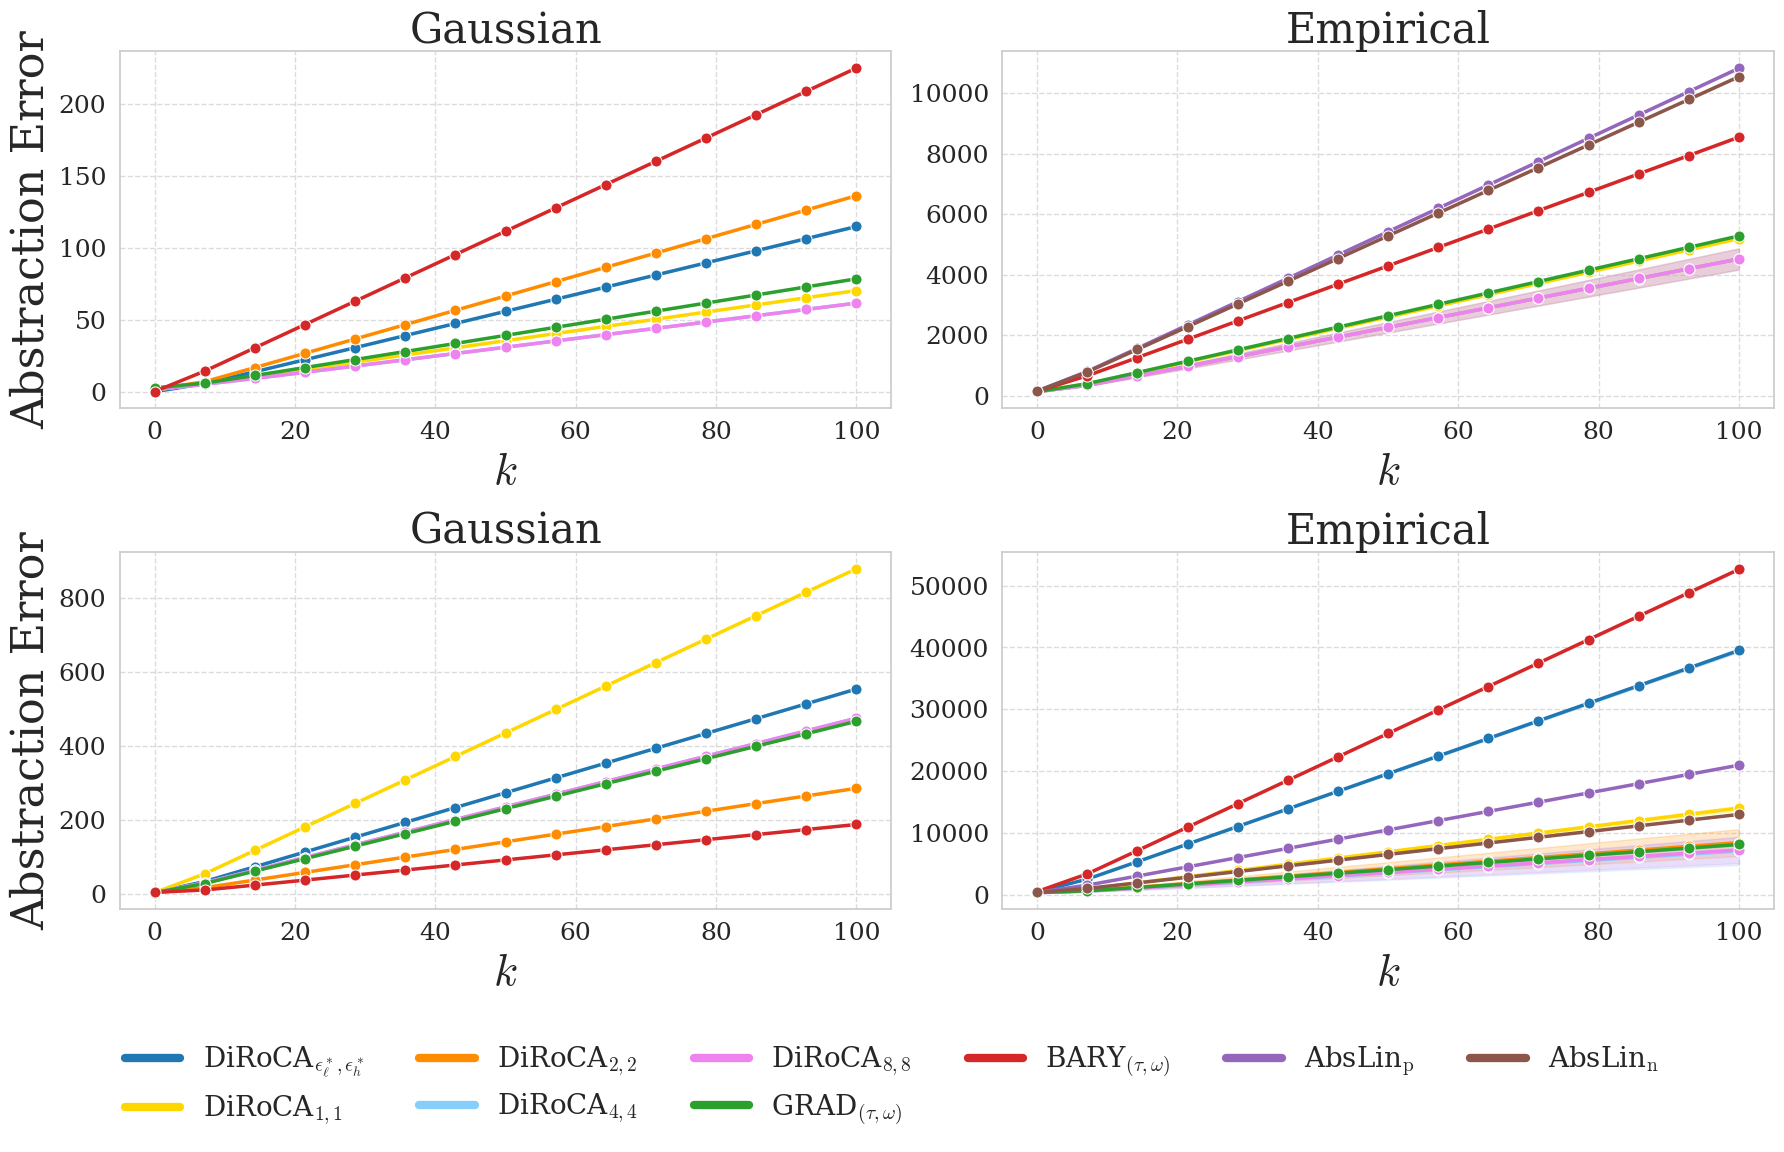

In [135]:
# -------------------------------------------
# Unified 2x2 figure with a single legend
# -------------------------------------------
k_values = np.linspace(0, 100, 15)
num_trials = 20
strength = 1
scaled = True
nonlinear_func = tanh  # your provided function

fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharey=False)
axes = np.array(axes).reshape(2, 2)

# (row, col) -> (experiment, setting)
panels = [
    ((0, 0), ('slc', 'gaussian'),   "Gaussian"),
    ((0, 1), ('slc', 'empirical'),  "Empirical"),
    ((1, 0), ('lilucas', 'gaussian'),  "Gaussian"),
    ((1, 1), ('lilucas', 'empirical'), "Empirical"),
]

# Track which display labels actually appear (to build one legend)
present_disp_names_global = []

for (r, c), (experiment, setting), title_str in panels:
    ax = axes[r, c]

    df_panel, keep_methods = run_k_sweep(
        experiment, setting, k_values,
        num_trials=num_trials, strength=strength,
        scaled=scaled, nonlinear_func=nonlinear_func
    )

    # Determine hue order only for methods present in this panel
    disp_order = [print_label_map[m] for m in methods_to_plot if m in keep_methods]

    if not df_panel.empty and disp_order:
        sns.lineplot(
            data=df_panel,
            x='k_value',
            y='error',
            hue='display_name',
            hue_order=disp_order,
            palette=color_map,
            marker='o',
            linewidth=2.5,
            markersize=8,
            errorbar='sd',
            ax=ax,
            legend=False  # unified legend later
        )
        # Accumulate present display names
        present_disp_names_global.extend(disp_order)

    # Titles & axes labels (keep your font sizes/style)
    ax.set_title(title_str, fontsize=30)
    ax.set_xlabel(r'$k$', fontsize=32)
    # Left column gets y-labels, right column hides them
    if c == 0:
        ax.set_ylabel('Abstraction Error', fontsize=32)
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='both', labelsize=18)
    ax.grid(True, linestyle='--', alpha=0.7)

# Build a unified legend using only the methods that appeared in any panel,
# but respecting your preferred global order (methods_to_plot -> display_names).
present_disp_names_global = [dn for dn in display_names if dn in set(present_disp_names_global)]

ordered_handles = [
    plt.Line2D([], [], linestyle='-', linewidth=6,
               label=dn, color=color_map.get(dn, '#000000'))
    for dn in present_disp_names_global
]

# Single legend centered below
fig.legend(
    ordered_handles,
    present_disp_names_global,
    loc='lower center',
    ncol=min(6, len(present_disp_names_global)),
    fontsize=20,
    frameon=False
)

# Optional: a compact super-title
# fig.suptitle("Abstraction Error vs Nonlinearity ($k$)", fontsize=34, y=0.98)

# Leave space at the bottom for the legend
fig.tight_layout(rect=[0, 0.12, 1, 0.97])
plt.savefig("plots/abstraction_vs_k_SLC_LiLuCas_2x2.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# --- DIROCA (Empirical) Cross-Validation with Training Curve Plotting ---

import os
import warnings
from itertools import product

import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import utilities as ut
import opt_tools as optools
import modularised_utils as mut
import evaluation_utils as evut
from run_empirical_evaluation import apply_huber_contamination

warnings.filterwarnings('ignore')

# =========================
# 0) Configuration
# =========================
experiment = 'slc'
# --- MODIFIED: Renamed for clarity ---
print(f"=== Running DIROCA (Empirical) Cross-Validation for {experiment} ===")

config_files = {
    'hyperparams_diroca': 'configs/diroca_opt_config_empirical.yaml',
    'hyperparams_gradca': 'configs/gradca_opt_config_empirical.yaml',
    'hyperparams_baryca': 'configs/baryca_opt_config_empirical.yaml'
}
configs = ut.load_configs(config_files)

# --- MODIFIED: Use DIROCA base hyperparameters ---
hyperparams_diroca = configs['hyperparams_diroca'] 

# Load model data
all_data = ut.load_all_data(experiment)
all_data['experiment_name'] = experiment

# Prepare CV folds
Dll_obs = all_data['LLmodel']['data'][None]
Dhl_obs = all_data['HLmodel']['data'][None]
folds_path = f"data/{experiment}/cv_folds.pkl"
saved_folds = ut.prepare_cv_folds(Dll_obs, hyperparams_diroca['k_folds'],
                                  hyperparams_diroca['seed'], folds_path)

# Empirical noise residuals
U_ll_hat = all_data['LLmodel']['noise'][None]
U_hl_hat = all_data['HLmodel']['noise'][None]

# For evaluation on endogenous data
Dll_samples = all_data['LLmodel']['data']
Dhl_samples = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
omega = all_data['abstraction_data']['omega']

# Variable names
ll_var_names = list(all_data['LLmodel']['graph'].nodes())
hl_var_names = list(all_data['HLmodel']['graph'].nodes())

# =========================
# 1) Base parameters (eps_delta will be looped over)
# =========================
# These are the fixed parameters for the optimizer. The main hyperparameter (eps_delta) is handled below.
base_params = {
    'eta_min': 0.001, 
    'tol': 0.00001,
    'max_iter': 5000,
    'seed': 23,
    'initialization': 'random'
}


print("1. Using base parameters for DIROCA run:", base_params)

# =========================
# 2) Helpers
# =========================
def calculate_empirical_error(T_matrix, Dll_test, Dhl_test, metric='fro'):
    if Dll_test.shape[0] == 0 or Dhl_test.shape[0] == 0:
        return np.nan
    try:
        Dhl_pred = Dll_test @ T_matrix.T
        err = evut.compute_empirical_distance(Dhl_pred.T, Dhl_test.T, metric)
    except Exception as e:
        print(f"  - Warning: empirical distance failed ({e}); returning NaN.")
        return np.nan
    return float(err)

# Rho-shift config
alpha_rho = 1.0
noise_scale_rho = 10.0 if experiment == 'lilucas' else 5.0
base_sigma_L = np.eye(len(ll_var_names))
base_sigma_H = np.eye(len(hl_var_names))
mu_scale_L = np.zeros(base_sigma_L.shape[0])
mu_scale_H = np.zeros(base_sigma_H.shape[0])
sigma_scale_L = base_sigma_L * (noise_scale_rho ** 2)
sigma_scale_H = base_sigma_H * (noise_scale_rho ** 2)
rho_shift_config = {
    'type': 'additive',
    'distribution': 'gaussian',
    'll_params': {'mu': mu_scale_L, 'sigma': sigma_scale_L},
    'hl_params': {'mu': mu_scale_H, 'sigma': sigma_scale_H},
}

# =========================
# 3) Run DIROCA Cross-Validation
# =========================
print("2. Running DIROCA cross-validation...")
diroca_cv_results_empirical = {}

for fold_idx, fold_info in enumerate(saved_folds):
    fold_key = f'fold_{fold_idx+1}'
    diroca_cv_results_empirical[fold_key] = {}
    print(f"\n--- Starting Empirical Optimization for Fold {fold_idx+1}/{len(saved_folds)} ---")

    # --- DIROCA-SPECIFIC: Define eps_delta values for this fold ---
    train_n = len(fold_info['train'])
    try:
        ll_bound = round(ut.compute_radius_lb(N=train_n, eta=0.05, c=1000), 3)
    except AttributeError:
        print("  - Warning: ut.compute_radius_lb not found. Using placeholder value 0.111.")
        ll_bound = 0.111
    eps_delta_values = [4, 8, 1, 2, ll_bound]
    
    # Get training residuals for this fold
    U_ll_train = U_ll_hat[fold_info['train']]
    U_hl_train = U_hl_hat[fold_info['train']]

    # --- DIROCA-SPECIFIC: Loop over eps_delta values ---
    for eps_delta in eps_delta_values:
        print(f"\n  --- Training for ε=δ = {eps_delta} ---")
        
        # Combine base DIROCA config with current loop params
        current_config = hyperparams_diroca.copy()
        current_config.update(base_params)
        # Set the epsilon and delta for this specific run
        current_config['epsilon'] = eps_delta
        current_config['delta'] = eps_delta

        params_for_this_run = ut.assemble_empirical_parameters(
            U_ll_train, U_hl_train, all_data, current_config
        )
        
        _allowed = {
            'U_L','U_H','L_models','H_models','omega','epsilon','delta',
            'eta_min','eta_max','num_steps_min','num_steps_max',
            'max_iter','tol','seed','robust_L','robust_H','initialization','experiment'
        }
        opt_args = {k: v for k, v in params_for_this_run.items() if k in _allowed}
        
        extra_keys = sorted(set(params_for_this_run) - set(_allowed))
        if extra_keys:
            print(f"  - Ignoring unexpected optimizer args: {extra_keys}")

        # 1. PREPARE EVALUATION DATA FOR THE CURRENT FOLD
        test_indices = fold_info['test']
        Dll_test_for_curve = np.concatenate([Dll_samples[iota][test_indices] for iota in I_ll_relevant], axis=0)
        Dhl_test_for_curve = np.concatenate([Dhl_samples[omega[iota]][test_indices] for iota in I_ll_relevant], axis=0)
        eval_data_for_opt = {'Dll_test': Dll_test_for_curve, 'Dhl_test': Dhl_test_for_curve}
        
        # 2. ADD NEW ARGUMENTS FOR THE OPTIMIZER FUNCTION
        opt_args['eval_func'] = calculate_empirical_error
        opt_args['eval_data'] = eval_data_for_opt

        # 3. CALL THE MODIFIED OPTIMIZER
        trained_params, trained_T, histories = optools.run_empirical_erica_optimization(**opt_args)
        
        # 4. PLOT THE CURVES
        fig, ax1 = plt.subplots(figsize=(10, 6))
        color = 'tab:blue'
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Training Objective Loss', color=color)
        ax1.plot(histories['train_loss'], color=color, label='Train Loss')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_yscale('log')

        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel('0-Shift Error (Test Set)', color=color)
        ax2.plot(histories['eval_iters'], histories['eval_error'], color=color, marker='.', linestyle='--', label='0-Shift Error')
        ax2.tick_params(axis='y', labelcolor=color)
        
        fig.tight_layout()
        plt.title(f'DIROCA Training Curves for Fold {fold_idx+1}, ε=δ={eps_delta}')
        plt.show(block=False)
        plt.pause(2)
        plt.close(fig)

        # 5. RUN FINAL EVALUATION
        errors_per_iota_0shift = [calculate_empirical_error(trained_T, Dll_samples[iota][test_indices], Dhl_samples[omega[iota]][test_indices]) for iota in I_ll_relevant]
        mean_error_0shift = np.nanmean([e for e in errors_per_iota_0shift if e is not np.nan])
        print(f"    > Final 0-shift mean error: {mean_error_0shift:.6f}")

        errors_per_iota_rhoshift = []
        for iota in I_ll_relevant:
            Dll_test_clean = Dll_samples[iota][test_indices]
            Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
            Dll_test_cont = apply_huber_contamination(Dll_test_clean, alpha_rho, rho_shift_config, ll_var_names, 'L', seed=fold_idx)
            Dhl_test_cont = apply_huber_contamination(Dhl_test_clean, alpha_rho, rho_shift_config, hl_var_names, 'H', seed=fold_idx)
            er = calculate_empirical_error(trained_T, Dll_test_cont, Dhl_test_cont)
            if not np.isnan(er):
                errors_per_iota_rhoshift.append(er)
        mean_error_rhoshift = np.nanmean(errors_per_iota_rhoshift) if errors_per_iota_rhoshift else np.nan
        print(f"    > Final Rho-shift mean error: {mean_error_rhoshift:.6f}")

        # 6. STORE RESULTS
        hyperparam_key = f'eps_delta_{eps_delta}'
        diroca_cv_results_empirical[fold_key][hyperparam_key] = {
            'T_matrix': trained_T,
            'optimization_params': trained_params,
            'histories': histories,
            'mean_error_0shift': mean_error_0shift,
            'mean_error_rhoshift': mean_error_rhoshift
        }


=== Running DIROCA (Empirical) Cross-Validation for slc ===
Data loaded for 'slc'.
Created and saved 5 folds to 'data/slc/cv_folds.pkl'
1. Using base parameters for DIROCA run: {'eta_min': 0.001, 'tol': 1e-05, 'max_iter': 5000, 'seed': 23, 'initialization': 'random'}
2. Running DIROCA cross-validation...

--- Starting Empirical Optimization for Fold 1/5 ---

  --- Training for ε=δ = 4 ---
  - Ignoring unexpected optimizer args: ['k_folds']


TypeError: run_empirical_erica_optimization() got an unexpected keyword argument 'eval_func'

In [ ]:
# --- DIROCA (Empirical) Cross-Validation with Training Curve Plotting ---

import os
import warnings
from itertools import product

import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import utilities as ut
import opt_tools as optools
import modularised_utils as mut
import evaluation_utils as evut
from run_empirical_evaluation import apply_huber_contamination

warnings.filterwarnings('ignore')

# =========================
# 0) Configuration
# =========================
experiment = 'slc'
# --- MODIFIED: Renamed for clarity ---
print(f"=== Running DIROCA (Empirical) Cross-Validation for {experiment} ===")

config_files = {
    'hyperparams_diroca': 'configs/diroca_opt_config_empirical.yaml',
    'hyperparams_gradca': 'configs/gradca_opt_config_empirical.yaml',
    'hyperparams_baryca': 'configs/baryca_opt_config_empirical.yaml'
}
configs = ut.load_configs(config_files)

# --- MODIFIED: Use DIROCA base hyperparameters ---
hyperparams_diroca = configs['hyperparams_diroca'] 

# Load model data
all_data = ut.load_all_data(experiment)
all_data['experiment_name'] = experiment

# Prepare CV folds
Dll_obs = all_data['LLmodel']['data'][None]
Dhl_obs = all_data['HLmodel']['data'][None]
folds_path = f"data/{experiment}/cv_folds.pkl"
saved_folds = ut.prepare_cv_folds(Dll_obs, hyperparams_diroca['k_folds'],
                                  hyperparams_diroca['seed'], folds_path)

# Empirical noise residuals
U_ll_hat = all_data['LLmodel']['noise'][None]
U_hl_hat = all_data['HLmodel']['noise'][None]

# For evaluation on endogenous data
Dll_samples = all_data['LLmodel']['data']
Dhl_samples = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
omega = all_data['abstraction_data']['omega']

# Variable names
ll_var_names = list(all_data['LLmodel']['graph'].nodes())
hl_var_names = list(all_data['HLmodel']['graph'].nodes())

# =========================
# 1) Base parameters (eps_delta will be looped over)
# =========================
# These are the fixed parameters for the optimizer. The main hyperparameter (eps_delta) is handled below.
base_params = {
    'eta_min': 0.001, 
    'tol': 0.00001,
    'max_iter': 5000,
    'seed': 23,
    'initialization': 'random'
}


print("1. Using base parameters for DIROCA run:", base_params)

# =========================
# 2) Helpers
# =========================
def calculate_empirical_error(T_matrix, Dll_test, Dhl_test, metric='fro'):
    if Dll_test.shape[0] == 0 or Dhl_test.shape[0] == 0:
        return np.nan
    try:
        Dhl_pred = Dll_test @ T_matrix.T
        err = evut.compute_empirical_distance(Dhl_pred.T, Dhl_test.T, metric)
    except Exception as e:
        print(f"  - Warning: empirical distance failed ({e}); returning NaN.")
        return np.nan
    return float(err)

# Rho-shift config
alpha_rho = 1.0
noise_scale_rho = 10.0 if experiment == 'lilucas' else 5.0
base_sigma_L = np.eye(len(ll_var_names))
base_sigma_H = np.eye(len(hl_var_names))
mu_scale_L = np.zeros(base_sigma_L.shape[0])
mu_scale_H = np.zeros(base_sigma_H.shape[0])
sigma_scale_L = base_sigma_L * (noise_scale_rho ** 2)
sigma_scale_H = base_sigma_H * (noise_scale_rho ** 2)
rho_shift_config = {
    'type': 'additive',
    'distribution': 'gaussian',
    'll_params': {'mu': mu_scale_L, 'sigma': sigma_scale_L},
    'hl_params': {'mu': mu_scale_H, 'sigma': sigma_scale_H},
}

# =========================
# 3) Run DIROCA Cross-Validation
# =========================
print("2. Running DIROCA cross-validation...")
diroca_cv_results_empirical = {}

for fold_idx, fold_info in enumerate(saved_folds):
    fold_key = f'fold_{fold_idx+1}'
    diroca_cv_results_empirical[fold_key] = {}
    print(f"\n--- Starting Empirical Optimization for Fold {fold_idx+1}/{len(saved_folds)} ---")

    # --- DIROCA-SPECIFIC: Define eps_delta values for this fold ---
    train_n = len(fold_info['train'])
    try:
        ll_bound = round(ut.compute_radius_lb(N=train_n, eta=0.05, c=1000), 3)
    except AttributeError:
        print("  - Warning: ut.compute_radius_lb not found. Using placeholder value 0.111.")
        ll_bound = 0.111
    eps_delta_values = [4, 8, 1, 2, ll_bound]
    
    # Get training residuals for this fold
    U_ll_train = U_ll_hat[fold_info['train']]
    U_hl_train = U_hl_hat[fold_info['train']]

    # --- DIROCA-SPECIFIC: Loop over eps_delta values ---
    for eps_delta in eps_delta_values:
        print(f"\n  --- Training for ε=δ = {eps_delta} ---")
        
        # Combine base DIROCA config with current loop params
        current_config = hyperparams_diroca.copy()
        current_config.update(base_params)
        # Set the epsilon and delta for this specific run
        current_config['epsilon'] = eps_delta
        current_config['delta'] = eps_delta

        params_for_this_run = ut.assemble_empirical_parameters(
            U_ll_train, U_hl_train, all_data, current_config
        )
        
        _allowed = {
            'U_L','U_H','L_models','H_models','omega','epsilon','delta',
            'eta_min','eta_max','num_steps_min','num_steps_max',
            'max_iter','tol','seed','robust_L','robust_H','initialization','experiment'
        }
        opt_args = {k: v for k, v in params_for_this_run.items() if k in _allowed}
        
        extra_keys = sorted(set(params_for_this_run) - set(_allowed))
        if extra_keys:
            print(f"  - Ignoring unexpected optimizer args: {extra_keys}")

        # 1. PREPARE EVALUATION DATA FOR THE CURRENT FOLD
        test_indices = fold_info['test']
        Dll_test_for_curve = np.concatenate([Dll_samples[iota][test_indices] for iota in I_ll_relevant], axis=0)
        Dhl_test_for_curve = np.concatenate([Dhl_samples[omega[iota]][test_indices] for iota in I_ll_relevant], axis=0)
        eval_data_for_opt = {'Dll_test': Dll_test_for_curve, 'Dhl_test': Dhl_test_for_curve}
        
        # 2. ADD NEW ARGUMENTS FOR THE OPTIMIZER FUNCTION
        opt_args['eval_func'] = calculate_empirical_error
        opt_args['eval_data'] = eval_data_for_opt

        # 3. CALL THE MODIFIED OPTIMIZER
        trained_params, trained_T, histories = optools.run_empirical_erica_optimization(**opt_args)
        
        # 4. PLOT THE CURVES
        fig, ax1 = plt.subplots(figsize=(10, 6))
        color = 'tab:blue'
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Training Objective Loss', color=color)
        ax1.plot(histories['train_loss'], color=color, label='Train Loss')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_yscale('log')

        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel('0-Shift Error (Test Set)', color=color)
        ax2.plot(histories['eval_iters'], histories['eval_error'], color=color, marker='.', linestyle='--', label='0-Shift Error')
        ax2.tick_params(axis='y', labelcolor=color)
        
        fig.tight_layout()
        plt.title(f'DIROCA Training Curves for Fold {fold_idx+1}, ε=δ={eps_delta}')
        plt.show(block=False)
        plt.pause(2)
        plt.close(fig)

        # 5. RUN FINAL EVALUATION
        errors_per_iota_0shift = [calculate_empirical_error(trained_T, Dll_samples[iota][test_indices], Dhl_samples[omega[iota]][test_indices]) for iota in I_ll_relevant]
        mean_error_0shift = np.nanmean([e for e in errors_per_iota_0shift if e is not np.nan])
        print(f"    > Final 0-shift mean error: {mean_error_0shift:.6f}")

        errors_per_iota_rhoshift = []
        for iota in I_ll_relevant:
            Dll_test_clean = Dll_samples[iota][test_indices]
            Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
            Dll_test_cont = apply_huber_contamination(Dll_test_clean, alpha_rho, rho_shift_config, ll_var_names, 'L', seed=fold_idx)
            Dhl_test_cont = apply_huber_contamination(Dhl_test_clean, alpha_rho, rho_shift_config, hl_var_names, 'H', seed=fold_idx)
            er = calculate_empirical_error(trained_T, Dll_test_cont, Dhl_test_cont)
            if not np.isnan(er):
                errors_per_iota_rhoshift.append(er)
        mean_error_rhoshift = np.nanmean(errors_per_iota_rhoshift) if errors_per_iota_rhoshift else np.nan
        print(f"    > Final Rho-shift mean error: {mean_error_rhoshift:.6f}")

        # 6. STORE RESULTS
        hyperparam_key = f'eps_delta_{eps_delta}'
        diroca_cv_results_empirical[fold_key][hyperparam_key] = {
            'T_matrix': trained_T,
            'optimization_params': trained_params,
            'histories': histories,
            'mean_error_0shift': mean_error_0shift,
            'mean_error_rhoshift': mean_error_rhoshift
        }


=== Running DIROCA (Empirical) Cross-Validation for slc ===
Data loaded for 'slc'.
Created and saved 5 folds to 'data/slc/cv_folds.pkl'
1. Using base parameters for DIROCA run: {'eta_min': 0.001, 'tol': 1e-05, 'max_iter': 5000, 'seed': 23, 'initialization': 'random'}
2. Running DIROCA cross-validation...

--- Starting Empirical Optimization for Fold 1/5 ---

  --- Training for ε=δ = 4 ---
  - Ignoring unexpected optimizer args: ['k_folds']


TypeError: run_empirical_erica_optimization() got an unexpected keyword argument 'eval_func'

In [ ]:
# --- DIROCA (Empirical) Cross-Validation with Training Curve Plotting ---

import os
import warnings
from itertools import product

import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import utilities as ut
import opt_tools as optools
import modularised_utils as mut
import evaluation_utils as evut
from run_empirical_evaluation import apply_huber_contamination

warnings.filterwarnings('ignore')

# =========================
# 0) Configuration
# =========================
experiment = 'slc'
# --- MODIFIED: Renamed for clarity ---
print(f"=== Running DIROCA (Empirical) Cross-Validation for {experiment} ===")

config_files = {
    'hyperparams_diroca': 'configs/diroca_opt_config_empirical.yaml',
    'hyperparams_gradca': 'configs/gradca_opt_config_empirical.yaml',
    'hyperparams_baryca': 'configs/baryca_opt_config_empirical.yaml'
}
configs = ut.load_configs(config_files)

# --- MODIFIED: Use DIROCA base hyperparameters ---
hyperparams_diroca = configs['hyperparams_diroca'] 

# Load model data
all_data = ut.load_all_data(experiment)
all_data['experiment_name'] = experiment

# Prepare CV folds
Dll_obs = all_data['LLmodel']['data'][None]
Dhl_obs = all_data['HLmodel']['data'][None]
folds_path = f"data/{experiment}/cv_folds.pkl"
saved_folds = ut.prepare_cv_folds(Dll_obs, hyperparams_diroca['k_folds'],
                                  hyperparams_diroca['seed'], folds_path)

# Empirical noise residuals
U_ll_hat = all_data['LLmodel']['noise'][None]
U_hl_hat = all_data['HLmodel']['noise'][None]

# For evaluation on endogenous data
Dll_samples = all_data['LLmodel']['data']
Dhl_samples = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
omega = all_data['abstraction_data']['omega']

# Variable names
ll_var_names = list(all_data['LLmodel']['graph'].nodes())
hl_var_names = list(all_data['HLmodel']['graph'].nodes())

# =========================
# 1) Base parameters (eps_delta will be looped over)
# =========================
# These are the fixed parameters for the optimizer. The main hyperparameter (eps_delta) is handled below.
base_params = {
    'eta_min': 0.001, 
    'tol': 0.00001,
    'max_iter': 5000,
    'seed': 23,
    'initialization': 'random'
}


print("1. Using base parameters for DIROCA run:", base_params)

# =========================
# 2) Helpers
# =========================
def calculate_empirical_error(T_matrix, Dll_test, Dhl_test, metric='fro'):
    if Dll_test.shape[0] == 0 or Dhl_test.shape[0] == 0:
        return np.nan
    try:
        Dhl_pred = Dll_test @ T_matrix.T
        err = evut.compute_empirical_distance(Dhl_pred.T, Dhl_test.T, metric)
    except Exception as e:
        print(f"  - Warning: empirical distance failed ({e}); returning NaN.")
        return np.nan
    return float(err)

# Rho-shift config
alpha_rho = 1.0
noise_scale_rho = 10.0 if experiment == 'lilucas' else 5.0
base_sigma_L = np.eye(len(ll_var_names))
base_sigma_H = np.eye(len(hl_var_names))
mu_scale_L = np.zeros(base_sigma_L.shape[0])
mu_scale_H = np.zeros(base_sigma_H.shape[0])
sigma_scale_L = base_sigma_L * (noise_scale_rho ** 2)
sigma_scale_H = base_sigma_H * (noise_scale_rho ** 2)
rho_shift_config = {
    'type': 'additive',
    'distribution': 'gaussian',
    'll_params': {'mu': mu_scale_L, 'sigma': sigma_scale_L},
    'hl_params': {'mu': mu_scale_H, 'sigma': sigma_scale_H},
}

# =========================
# 3) Run DIROCA Cross-Validation
# =========================
print("2. Running DIROCA cross-validation...")
diroca_cv_results_empirical = {}

for fold_idx, fold_info in enumerate(saved_folds):
    fold_key = f'fold_{fold_idx+1}'
    diroca_cv_results_empirical[fold_key] = {}
    print(f"\n--- Starting Empirical Optimization for Fold {fold_idx+1}/{len(saved_folds)} ---")

    # --- DIROCA-SPECIFIC: Define eps_delta values for this fold ---
    train_n = len(fold_info['train'])
    try:
        ll_bound = round(ut.compute_radius_lb(N=train_n, eta=0.05, c=1000), 3)
    except AttributeError:
        print("  - Warning: ut.compute_radius_lb not found. Using placeholder value 0.111.")
        ll_bound = 0.111
    eps_delta_values = [4, 8, 1, 2, ll_bound]
    
    # Get training residuals for this fold
    U_ll_train = U_ll_hat[fold_info['train']]
    U_hl_train = U_hl_hat[fold_info['train']]

    # --- DIROCA-SPECIFIC: Loop over eps_delta values ---
    for eps_delta in eps_delta_values:
        print(f"\n  --- Training for ε=δ = {eps_delta} ---")
        
        # Combine base DIROCA config with current loop params
        current_config = hyperparams_diroca.copy()
        current_config.update(base_params)
        # Set the epsilon and delta for this specific run
        current_config['epsilon'] = eps_delta
        current_config['delta'] = eps_delta

        params_for_this_run = ut.assemble_empirical_parameters(
            U_ll_train, U_hl_train, all_data, current_config
        )
        
        _allowed = {
            'U_L','U_H','L_models','H_models','omega','epsilon','delta',
            'eta_min','eta_max','num_steps_min','num_steps_max',
            'max_iter','tol','seed','robust_L','robust_H','initialization','experiment'
        }
        opt_args = {k: v for k, v in params_for_this_run.items() if k in _allowed}
        
        extra_keys = sorted(set(params_for_this_run) - set(_allowed))
        if extra_keys:
            print(f"  - Ignoring unexpected optimizer args: {extra_keys}")

        # 1. PREPARE EVALUATION DATA FOR THE CURRENT FOLD
        test_indices = fold_info['test']
        Dll_test_for_curve = np.concatenate([Dll_samples[iota][test_indices] for iota in I_ll_relevant], axis=0)
        Dhl_test_for_curve = np.concatenate([Dhl_samples[omega[iota]][test_indices] for iota in I_ll_relevant], axis=0)
        eval_data_for_opt = {'Dll_test': Dll_test_for_curve, 'Dhl_test': Dhl_test_for_curve}
        
        # 2. ADD NEW ARGUMENTS FOR THE OPTIMIZER FUNCTION
        opt_args['eval_func'] = calculate_empirical_error
        opt_args['eval_data'] = eval_data_for_opt

        # 3. CALL THE MODIFIED OPTIMIZER
        trained_params, trained_T, histories = optools.run_empirical_erica_optimization(**opt_args)
        
        # 4. PLOT THE CURVES
        fig, ax1 = plt.subplots(figsize=(10, 6))
        color = 'tab:blue'
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Training Objective Loss', color=color)
        ax1.plot(histories['train_loss'], color=color, label='Train Loss')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_yscale('log')

        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel('0-Shift Error (Test Set)', color=color)
        ax2.plot(histories['eval_iters'], histories['eval_error'], color=color, marker='.', linestyle='--', label='0-Shift Error')
        ax2.tick_params(axis='y', labelcolor=color)
        
        fig.tight_layout()
        plt.title(f'DIROCA Training Curves for Fold {fold_idx+1}, ε=δ={eps_delta}')
        plt.show(block=False)
        plt.pause(2)
        plt.close(fig)

        # 5. RUN FINAL EVALUATION
        errors_per_iota_0shift = [calculate_empirical_error(trained_T, Dll_samples[iota][test_indices], Dhl_samples[omega[iota]][test_indices]) for iota in I_ll_relevant]
        mean_error_0shift = np.nanmean([e for e in errors_per_iota_0shift if e is not np.nan])
        print(f"    > Final 0-shift mean error: {mean_error_0shift:.6f}")

        errors_per_iota_rhoshift = []
        for iota in I_ll_relevant:
            Dll_test_clean = Dll_samples[iota][test_indices]
            Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
            Dll_test_cont = apply_huber_contamination(Dll_test_clean, alpha_rho, rho_shift_config, ll_var_names, 'L', seed=fold_idx)
            Dhl_test_cont = apply_huber_contamination(Dhl_test_clean, alpha_rho, rho_shift_config, hl_var_names, 'H', seed=fold_idx)
            er = calculate_empirical_error(trained_T, Dll_test_cont, Dhl_test_cont)
            if not np.isnan(er):
                errors_per_iota_rhoshift.append(er)
        mean_error_rhoshift = np.nanmean(errors_per_iota_rhoshift) if errors_per_iota_rhoshift else np.nan
        print(f"    > Final Rho-shift mean error: {mean_error_rhoshift:.6f}")

        # 6. STORE RESULTS
        hyperparam_key = f'eps_delta_{eps_delta}'
        diroca_cv_results_empirical[fold_key][hyperparam_key] = {
            'T_matrix': trained_T,
            'optimization_params': trained_params,
            'histories': histories,
            'mean_error_0shift': mean_error_0shift,
            'mean_error_rhoshift': mean_error_rhoshift
        }


=== Running DIROCA (Empirical) Cross-Validation for slc ===
Data loaded for 'slc'.
Created and saved 5 folds to 'data/slc/cv_folds.pkl'
1. Using base parameters for DIROCA run: {'eta_min': 0.001, 'tol': 1e-05, 'max_iter': 5000, 'seed': 23, 'initialization': 'random'}
2. Running DIROCA cross-validation...

--- Starting Empirical Optimization for Fold 1/5 ---

  --- Training for ε=δ = 4 ---
  - Ignoring unexpected optimizer args: ['k_folds']


TypeError: run_empirical_erica_optimization() got an unexpected keyword argument 'eval_func'

In [ ]:
# --- DIROCA (Empirical) Cross-Validation with Training Curve Plotting ---

import os
import warnings
from itertools import product

import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import utilities as ut
import opt_tools as optools
import modularised_utils as mut
import evaluation_utils as evut
from run_empirical_evaluation import apply_huber_contamination

warnings.filterwarnings('ignore')

# =========================
# 0) Configuration
# =========================
experiment = 'slc'
# --- MODIFIED: Renamed for clarity ---
print(f"=== Running DIROCA (Empirical) Cross-Validation for {experiment} ===")

config_files = {
    'hyperparams_diroca': 'configs/diroca_opt_config_empirical.yaml',
    'hyperparams_gradca': 'configs/gradca_opt_config_empirical.yaml',
    'hyperparams_baryca': 'configs/baryca_opt_config_empirical.yaml'
}
configs = ut.load_configs(config_files)

# --- MODIFIED: Use DIROCA base hyperparameters ---
hyperparams_diroca = configs['hyperparams_diroca'] 

# Load model data
all_data = ut.load_all_data(experiment)
all_data['experiment_name'] = experiment

# Prepare CV folds
Dll_obs = all_data['LLmodel']['data'][None]
Dhl_obs = all_data['HLmodel']['data'][None]
folds_path = f"data/{experiment}/cv_folds.pkl"
saved_folds = ut.prepare_cv_folds(Dll_obs, hyperparams_diroca['k_folds'],
                                  hyperparams_diroca['seed'], folds_path)

# Empirical noise residuals
U_ll_hat = all_data['LLmodel']['noise'][None]
U_hl_hat = all_data['HLmodel']['noise'][None]

# For evaluation on endogenous data
Dll_samples = all_data['LLmodel']['data']
Dhl_samples = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
omega = all_data['abstraction_data']['omega']

# Variable names
ll_var_names = list(all_data['LLmodel']['graph'].nodes())
hl_var_names = list(all_data['HLmodel']['graph'].nodes())

# =========================
# 1) Base parameters (eps_delta will be looped over)
# =========================
# These are the fixed parameters for the optimizer. The main hyperparameter (eps_delta) is handled below.
base_params = {
    'eta_min': 0.001, 
    'tol': 0.00001,
    'max_iter': 5000,
    'seed': 23,
    'initialization': 'random'
}


print("1. Using base parameters for DIROCA run:", base_params)

# =========================
# 2) Helpers
# =========================
def calculate_empirical_error(T_matrix, Dll_test, Dhl_test, metric='fro'):
    if Dll_test.shape[0] == 0 or Dhl_test.shape[0] == 0:
        return np.nan
    try:
        Dhl_pred = Dll_test @ T_matrix.T
        err = evut.compute_empirical_distance(Dhl_pred.T, Dhl_test.T, metric)
    except Exception as e:
        print(f"  - Warning: empirical distance failed ({e}); returning NaN.")
        return np.nan
    return float(err)

# Rho-shift config
alpha_rho = 1.0
noise_scale_rho = 10.0 if experiment == 'lilucas' else 5.0
base_sigma_L = np.eye(len(ll_var_names))
base_sigma_H = np.eye(len(hl_var_names))
mu_scale_L = np.zeros(base_sigma_L.shape[0])
mu_scale_H = np.zeros(base_sigma_H.shape[0])
sigma_scale_L = base_sigma_L * (noise_scale_rho ** 2)
sigma_scale_H = base_sigma_H * (noise_scale_rho ** 2)
rho_shift_config = {
    'type': 'additive',
    'distribution': 'gaussian',
    'll_params': {'mu': mu_scale_L, 'sigma': sigma_scale_L},
    'hl_params': {'mu': mu_scale_H, 'sigma': sigma_scale_H},
}

# =========================
# 3) Run DIROCA Cross-Validation
# =========================
print("2. Running DIROCA cross-validation...")
diroca_cv_results_empirical = {}

for fold_idx, fold_info in enumerate(saved_folds):
    fold_key = f'fold_{fold_idx+1}'
    diroca_cv_results_empirical[fold_key] = {}
    print(f"\n--- Starting Empirical Optimization for Fold {fold_idx+1}/{len(saved_folds)} ---")

    # --- DIROCA-SPECIFIC: Define eps_delta values for this fold ---
    train_n = len(fold_info['train'])
    try:
        ll_bound = round(ut.compute_radius_lb(N=train_n, eta=0.05, c=1000), 3)
    except AttributeError:
        print("  - Warning: ut.compute_radius_lb not found. Using placeholder value 0.111.")
        ll_bound = 0.111
    eps_delta_values = [4, 8, 1, 2, ll_bound]
    
    # Get training residuals for this fold
    U_ll_train = U_ll_hat[fold_info['train']]
    U_hl_train = U_hl_hat[fold_info['train']]

    # --- DIROCA-SPECIFIC: Loop over eps_delta values ---
    for eps_delta in eps_delta_values:
        print(f"\n  --- Training for ε=δ = {eps_delta} ---")
        
        # Combine base DIROCA config with current loop params
        current_config = hyperparams_diroca.copy()
        current_config.update(base_params)
        # Set the epsilon and delta for this specific run
        current_config['epsilon'] = eps_delta
        current_config['delta'] = eps_delta

        params_for_this_run = ut.assemble_empirical_parameters(
            U_ll_train, U_hl_train, all_data, current_config
        )
        
        _allowed = {
            'U_L','U_H','L_models','H_models','omega','epsilon','delta',
            'eta_min','eta_max','num_steps_min','num_steps_max',
            'max_iter','tol','seed','robust_L','robust_H','initialization','experiment'
        }
        opt_args = {k: v for k, v in params_for_this_run.items() if k in _allowed}
        
        extra_keys = sorted(set(params_for_this_run) - set(_allowed))
        if extra_keys:
            print(f"  - Ignoring unexpected optimizer args: {extra_keys}")

        # 1. PREPARE EVALUATION DATA FOR THE CURRENT FOLD
        test_indices = fold_info['test']
        Dll_test_for_curve = np.concatenate([Dll_samples[iota][test_indices] for iota in I_ll_relevant], axis=0)
        Dhl_test_for_curve = np.concatenate([Dhl_samples[omega[iota]][test_indices] for iota in I_ll_relevant], axis=0)
        eval_data_for_opt = {'Dll_test': Dll_test_for_curve, 'Dhl_test': Dhl_test_for_curve}
        
        # 2. ADD NEW ARGUMENTS FOR THE OPTIMIZER FUNCTION
        opt_args['eval_func'] = calculate_empirical_error
        opt_args['eval_data'] = eval_data_for_opt

        # 3. CALL THE MODIFIED OPTIMIZER
        trained_params, trained_T, histories = optools.run_empirical_erica_optimization(**opt_args)
        
        # 4. PLOT THE CURVES
        fig, ax1 = plt.subplots(figsize=(10, 6))
        color = 'tab:blue'
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Training Objective Loss', color=color)
        ax1.plot(histories['train_loss'], color=color, label='Train Loss')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_yscale('log')

        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel('0-Shift Error (Test Set)', color=color)
        ax2.plot(histories['eval_iters'], histories['eval_error'], color=color, marker='.', linestyle='--', label='0-Shift Error')
        ax2.tick_params(axis='y', labelcolor=color)
        
        fig.tight_layout()
        plt.title(f'DIROCA Training Curves for Fold {fold_idx+1}, ε=δ={eps_delta}')
        plt.show(block=False)
        plt.pause(2)
        plt.close(fig)

        # 5. RUN FINAL EVALUATION
        errors_per_iota_0shift = [calculate_empirical_error(trained_T, Dll_samples[iota][test_indices], Dhl_samples[omega[iota]][test_indices]) for iota in I_ll_relevant]
        mean_error_0shift = np.nanmean([e for e in errors_per_iota_0shift if e is not np.nan])
        print(f"    > Final 0-shift mean error: {mean_error_0shift:.6f}")

        errors_per_iota_rhoshift = []
        for iota in I_ll_relevant:
            Dll_test_clean = Dll_samples[iota][test_indices]
            Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
            Dll_test_cont = apply_huber_contamination(Dll_test_clean, alpha_rho, rho_shift_config, ll_var_names, 'L', seed=fold_idx)
            Dhl_test_cont = apply_huber_contamination(Dhl_test_clean, alpha_rho, rho_shift_config, hl_var_names, 'H', seed=fold_idx)
            er = calculate_empirical_error(trained_T, Dll_test_cont, Dhl_test_cont)
            if not np.isnan(er):
                errors_per_iota_rhoshift.append(er)
        mean_error_rhoshift = np.nanmean(errors_per_iota_rhoshift) if errors_per_iota_rhoshift else np.nan
        print(f"    > Final Rho-shift mean error: {mean_error_rhoshift:.6f}")

        # 6. STORE RESULTS
        hyperparam_key = f'eps_delta_{eps_delta}'
        diroca_cv_results_empirical[fold_key][hyperparam_key] = {
            'T_matrix': trained_T,
            'optimization_params': trained_params,
            'histories': histories,
            'mean_error_0shift': mean_error_0shift,
            'mean_error_rhoshift': mean_error_rhoshift
        }


=== Running DIROCA (Empirical) Cross-Validation for slc ===
Data loaded for 'slc'.
Created and saved 5 folds to 'data/slc/cv_folds.pkl'
1. Using base parameters for DIROCA run: {'eta_min': 0.001, 'tol': 1e-05, 'max_iter': 5000, 'seed': 23, 'initialization': 'random'}
2. Running DIROCA cross-validation...

--- Starting Empirical Optimization for Fold 1/5 ---

  --- Training for ε=δ = 4 ---
  - Ignoring unexpected optimizer args: ['k_folds']


TypeError: run_empirical_erica_optimization() got an unexpected keyword argument 'eval_func'

In [143]:
# Paired t-tests for contamination analysis
from scipy.stats import ttest_rel
import warnings
warnings.filterwarnings('ignore')

# Get the best method (lowest mean error)
best_method = summary['mean'].idxmin()
best_mean = summary.loc[best_method, 'mean']

print(f"\nBest method: {best_method} (mean error: {best_mean:.4f})")
print("\nPaired t-tests (best vs others):")
print("="*60)

# Get data for best method
best_data = f_spec_df[f_spec_df['method'] == best_method]['error'].values

# Compare against all other methods
for method in summary.index:
    if method != best_method:
        other_data = f_spec_df[f_spec_df['method'] == method]['error'].values
        
        # Ensure same number of observations for paired test
        min_len = min(len(best_data), len(other_data))
        if min_len > 0:
            t_stat, p_value = ttest_rel(best_data[:min_len], other_data[:min_len])
            other_mean = summary.loc[method, 'mean']
            diff = best_mean - other_mean
            
            print(f"{best_method} vs {method:<30} | p={p_value:.4f} | diff={diff:.4f} | {'Significant' if p_value < 0.05 else 'Not significant'}")
        else:
            print(f"{best_method} vs {method:<30} | No data available")



Best method: DIROCA_2 (mean error: 3.9874)

Paired t-tests (best vs others):
DIROCA_2 vs BARYCA                         | p=0.0000 | diff=-0.2617 | Significant
DIROCA_2 vs DIROCA_1                       | p=0.0000 | diff=-1.9917 | Significant
DIROCA_2 vs DIROCA_4                       | p=0.0000 | diff=-0.6409 | Significant
DIROCA_2 vs DIROCA_8                       | p=0.0000 | diff=-0.6409 | Significant
DIROCA_2 vs DiRoCA_star                    | p=0.0000 | diff=-2.0197 | Significant
DIROCA_2 vs GradCA                         | p=0.0000 | diff=-1.8747 | Significant


In [12]:
# Test specific methods vs all others
def test_method_vs_all(target_method):
    """Test a specific method against all other methods."""
    target_data = f_spec_df[f_spec_df['method'] == target_method]['error'].values
    target_mean = np.mean(target_data)
    
    print(f"\n{target_method} vs all others:")
    print(f"{target_method} mean: {target_mean:.4f}")
    print("="*60)
    
    for method in summary.index:
        if method != target_method:
            other_data = f_spec_df[f_spec_df['method'] == method]['error'].values
            
            min_len = min(len(target_data), len(other_data))
            if min_len > 0:
                t_stat, p_value = ttest_rel(target_data[:min_len], other_data[:min_len])
                other_mean = np.mean(other_data[:min_len])
                diff = target_mean - other_mean
                
                print(f"{target_method} vs {method:<30} | p={p_value:.4f} | diff={diff:.4f} | {'Significant' if p_value < 0.05 else 'Not significant'}")
            else:
                print(f"{target_method} vs {method:<30} | No data available")

# Test DiRoCA_star vs all and DIROCA_2 vs all
print("\n" + "="*60)
print("SPECIFIC METHOD vs ALL OTHERS")
print("="*60)

test_method_vs_all('DiRoCA_star')
test_method_vs_all('DIROCA_2')



SPECIFIC METHOD vs ALL OTHERS

DiRoCA_star vs all others:
DiRoCA_star mean: 46947.3862
DiRoCA_star vs BARYCA                         | p=0.0000 | diff=35667.5827 | Significant
DiRoCA_star vs DIROCA_1                       | p=0.0000 | diff=-21541.2685 | Significant
DiRoCA_star vs DIROCA_2                       | p=0.0000 | diff=27575.1796 | Significant
DiRoCA_star vs DIROCA_4                       | p=0.0000 | diff=12310.1865 | Significant
DiRoCA_star vs DIROCA_8                       | p=0.0000 | diff=12310.1865 | Significant
DiRoCA_star vs GradCA                         | p=0.0000 | diff=893.6385 | Significant

DIROCA_2 vs all others:
DIROCA_2 mean: 19372.2066
DIROCA_2 vs BARYCA                         | p=0.0000 | diff=8092.4032 | Significant
DIROCA_2 vs DIROCA_1                       | p=0.0000 | diff=-49116.4480 | Significant
DIROCA_2 vs DIROCA_4                       | p=0.0000 | diff=-15264.9931 | Significant
DIROCA_2 vs DIROCA_8                       | p=0.0000 | diff=-15264.9

In [47]:
# Compile results into a DataFrame
f_spec_df = pd.DataFrame(f_spec_records)

print("\n--- F-Misspecification Evaluation Complete ---")
print("="*65)
print("Overall Performance (Averaged Across All Nonlinearity Strengths)")
print("="*65)
print(f"{'Method/Run':<35} | {'Mean ± Std'}")
print("="*65)

summary = f_spec_df.groupby('method')['error'].agg(['mean', 'std', 'count'])
summary['sem'] = summary['std']  # You can uncomment next line for CI
# summary['sem'] = summary['std'] / np.sqrt(summary['count'])
summary['ci95'] = summary['sem']  # or 1.96 * sem

for method_name, row in summary.sort_values('mean').iterrows():
    print(f"{method_name:<35} | {row['mean']:.4f} ± {row['ci95']:.4f}")



--- F-Misspecification Evaluation Complete ---
Overall Performance (Averaged Across All Nonlinearity Strengths)
Method/Run                          | Mean ± Std
BARYCA                              | 11279.8034 ± 1329.8171
DIROCA_2                            | 19372.2066 ± 2292.2639
DIROCA_4                            | 34637.1997 ± 4096.0465
DIROCA_8                            | 34637.1997 ± 4096.0465
GradCA                              | 46053.7477 ± 5458.8700
DiRoCA_star                         | 46947.3862 ± 5555.6229
DIROCA_1                            | 68488.6546 ± 8090.2778


In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# This cell assumes all necessary data (saved_folds, all_data, results_to_evaluate, etc.)
# and helper functions (apply_structural_contamination, calculate_error) are already defined.

# ======================================================================
# 1. CONTROL PANEL: Configure the F-Misspecification Experiment
# ======================================================================

# The range of non-linearity strengths to test (from 0% to 100% non-linear)
contamination_strengths = [1]

# The specific non-linear function to use
nonlinear_funcs = [square, tanh, sin, relu, leaky_relu, relu_squared]

# How to combine linear and non-linear parts
scaled = True # Use 'True' to smoothly interpolate from linear to non-linear

# How to generate the data
reuse = False # Use 'False' to simulate a new, ground-truth non-linear SCM

# Number of random trials (for stability if non-linear function has randomness)
num_trials = 1 

# ======================================================================
# 2. THE EVALUATION LOOP
# ======================================================================
for nonlinear_func in nonlinear_funcs:
    print(f"🚀 Starting F-misspecification evaluation for {nonlinear_func.__name__}...")
    f_spec_records = []
    print(f"🚀 Starting F-misspecification evaluation...")

    for strength in tqdm(contamination_strengths, desc="Non-linearity Strength"):
        for trial in range(num_trials):
            for i, fold_info in enumerate(saved_folds):
                for method_name, results_dict in results_to_evaluate.items():
                    fold_results = results_dict.get(f'fold_{i}', {})
                    for run_key, run_data in fold_results.items():
                        
                        T_learned = run_data['T_matrix']
                        test_indices = run_data['test_indices']
                        
                        errors_per_intervention = []
                        for iota in I_ll_relevant:
                            Dll_clean = Dll_samples[iota][test_indices]
                            Dhl_clean = Dhl_samples[omega[iota]][test_indices]
                            noise_ll = LLmodel['noise'][iota][test_indices]
                            noise_hl = HLmodel['noise'][omega[iota]][test_indices]
                            scm_ll = LLmodel['scm_instances'][iota]
                            scm_hl = HLmodel['scm_instances'][omega[iota]]

                            # Apply contamination based on current strategy
                            Dll_cont = apply_structural_contamination(
                                linear_data=Dll_clean,
                                graph=ll_graph,
                                coeffs=LLmodel['coeffs'],
                                noise=noise_ll,
                                strength=strength,
                                zero_linear=zero_linear,
                                scaled=scaled,
                                nonlinear_func=nonlinear_func
                            )

                            Dhl_cont = apply_structural_contamination(
                                linear_data=Dhl_clean,
                                graph=hl_graph,
                                coeffs=HLmodel['coeffs'],
                                noise=noise_hl,
                                strength=strength,
                                zero_linear=zero_linear,
                                scaled=scaled,
                                nonlinear_func=nonlinear_func
                            )

                            if setting == 'gaussian':
                                error = ut.calculate_abstraction_error(T_learned, Dll_cont, Dhl_cont)
                            elif setting == 'empirical':
                                error = ut.calculate_empirical_error(T_learned, Dll_cont, Dhl_cont)
                            else:
                                raise ValueError(f"Unknown setting: {setting}")

                            if not np.isnan(error):
                                errors_per_intervention.append(error)
                        
                        avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
                        
                        record = {
                            'method': method_name,
                            'contamination': strength,
                            'trial': trial,
                            'fold': i,
                            'error': avg_error
                        }
                        f_spec_records.append(record)

    # ======================================================================
    # 3. ANALYSIS AND VISUALIZATION
    # ======================================================================
    f_spec_df = pd.DataFrame(f_spec_records)
    print("\n--- F-Misspecification Evaluation Complete ---")

    # --- b. Print the Final Summary Table ---
    print("\n" + "="*65)
    print(f"Overall Performance (Averaged Across All Non-linearity Strengths)")
    print("="*65)
    print(f"{'Method/Run':<35} | {'Mean Error ± 95% CI'}")
    print("="*65)

    summary = f_spec_df.groupby('method')['error'].agg(['mean', 'std', 'count'])
    summary['sem'] = summary['std'] / np.sqrt(summary['count'])
    summary['ci95'] = 1.96 * summary['sem']

    for method_name, row in summary.sort_values('mean').iterrows():
        print(f"{method_name:<35} | {row['mean']:.4f} ± {row['ci95']:.4f}")
    print("="*65)

🚀 Starting F-misspecification evaluation for square...
🚀 Starting F-misspecification evaluation...


Non-linearity Strength: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]



--- F-Misspecification Evaluation Complete ---

Overall Performance (Averaged Across All Non-linearity Strengths)
Method/Run                          | Mean Error ± 95% CI
DIROCA_8                            | 687.6639 ± 22.2902
DIROCA_4                            | 690.0501 ± 18.1123
DIROCA_2                            | 690.0803 ± 18.0611
DIROCA_1                            | 721.5834 ± 12.6924
GradCA                              | 765.7768 ± 12.9878
DIROCA (eps_0.107_delta_0.035)      | 816.4454 ± 12.9089
BARYCA                              | 820.9618 ± 13.3200
Abslin_p                            | 918.2648 ± 19.6433
Abslin_n                            | 934.4303 ± 19.0749
🚀 Starting F-misspecification evaluation for tanh...
🚀 Starting F-misspecification evaluation...


Non-linearity Strength: 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]



--- F-Misspecification Evaluation Complete ---

Overall Performance (Averaged Across All Non-linearity Strengths)
Method/Run                          | Mean Error ± 95% CI
DIROCA_8                            | 136.9194 ± 0.4372
DIROCA_2                            | 136.9886 ± 0.4091
DIROCA_4                            | 136.9909 ± 0.4089
DIROCA_1                            | 138.8915 ± 0.8176
GradCA                              | 140.0687 ± 0.8529
BARYCA                              | 186.9390 ± 1.3550
Abslin_n                            | 191.7883 ± 1.5275
DIROCA (eps_0.107_delta_0.035)      | 192.7314 ± 1.3998
Abslin_p                            | 195.2346 ± 1.5835
🚀 Starting F-misspecification evaluation for sin...
🚀 Starting F-misspecification evaluation...


Non-linearity Strength: 100%|██████████| 1/1 [00:00<00:00,  9.69it/s]



--- F-Misspecification Evaluation Complete ---

Overall Performance (Averaged Across All Non-linearity Strengths)
Method/Run                          | Mean Error ± 95% CI
DIROCA_8                            | 135.3210 ± 0.5025
DIROCA_2                            | 135.3397 ± 0.4932
DIROCA_4                            | 135.3417 ± 0.4923
DIROCA_1                            | 137.3671 ± 0.8922
GradCA                              | 138.3307 ± 0.9338
BARYCA                              | 185.8439 ± 1.4588
Abslin_n                            | 190.5806 ± 1.6309
DIROCA (eps_0.107_delta_0.035)      | 191.6808 ± 1.5050
Abslin_p                            | 198.3882 ± 1.6561
🚀 Starting F-misspecification evaluation for relu...
🚀 Starting F-misspecification evaluation...


Non-linearity Strength: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]



--- F-Misspecification Evaluation Complete ---

Overall Performance (Averaged Across All Non-linearity Strengths)
Method/Run                          | Mean Error ± 95% CI
DIROCA_8                            | 161.3557 ± 1.5651
DIROCA_2                            | 161.7082 ± 0.9140
DIROCA_4                            | 161.7096 ± 0.9114
DIROCA_1                            | 165.4976 ± 0.9090
GradCA                              | 168.0141 ± 0.8584
BARYCA                              | 213.8516 ± 1.1630
DIROCA (eps_0.107_delta_0.035)      | 217.8858 ± 1.1763
Abslin_p                            | 221.3529 ± 1.3903
Abslin_n                            | 223.8568 ± 1.2380
🚀 Starting F-misspecification evaluation for leaky_relu...
🚀 Starting F-misspecification evaluation...


Non-linearity Strength: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]



--- F-Misspecification Evaluation Complete ---

Overall Performance (Averaged Across All Non-linearity Strengths)
Method/Run                          | Mean Error ± 95% CI
DIROCA_8                            | 161.5885 ± 1.4799
DIROCA_2                            | 161.9125 ± 0.8840
DIROCA_4                            | 161.9140 ± 0.8814
DIROCA_1                            | 165.6123 ± 0.9176
GradCA                              | 168.0933 ± 0.8710
BARYCA                              | 214.9600 ± 1.1844
DIROCA (eps_0.107_delta_0.035)      | 219.2583 ± 1.1997
Abslin_p                            | 222.4817 ± 1.4102
Abslin_n                            | 224.7454 ± 1.2639
🚀 Starting F-misspecification evaluation for relu_squared...
🚀 Starting F-misspecification evaluation...


Non-linearity Strength: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


--- F-Misspecification Evaluation Complete ---

Overall Performance (Averaged Across All Non-linearity Strengths)
Method/Run                          | Mean Error ± 95% CI
DIROCA_8                            | 494.0063 ± 21.9495
DIROCA_4                            | 495.3042 ± 19.9226
DIROCA_2                            | 495.3213 ± 19.8967
DIROCA_1                            | 516.1138 ± 16.9827
GradCA                              | 546.7909 ± 18.4987
DIROCA (eps_0.107_delta_0.035)      | 598.4269 ± 18.0746
BARYCA                              | 598.6891 ± 18.5568
Abslin_p                            | 673.7700 ± 25.2679
Abslin_n                            | 681.9198 ± 25.0046


In [110]:
for func in [square, tanh, sin, exp, relu, leaky_relu, relu_squared]:
    f_spec_records = []
    for strength in tqdm(contamination_strengths, desc="Contamination Strength"):
        for trial in range(num_trials):
            for i, fold_info in enumerate(saved_folds):
                for method_name, results_dict in results_to_evaluate.items():
                    fold_results = results_dict.get(f'fold_{i}', {})
                    for run_key, run_data in fold_results.items():
                        T_learned = run_data['T_matrix']
                        test_indices = run_data['test_indices']

                        errors_per_intervention = []

                        for iota in I_ll_relevant:
                            # Prepare inputs
                            Dll_clean = Dll_samples[iota][test_indices]
                            Dhl_clean = Dhl_samples[omega[iota]][test_indices]

                            noise_ll = LLmodel['noise'][iota][test_indices]
                            noise_hl = HLmodel['noise'][omega[iota]][test_indices]

                            # Apply contamination based on current strategy
                            Dll_cont = apply_structural_contamination(
                                linear_data=Dll_clean,
                                graph=ll_graph,
                                coeffs=LLmodel['coeffs'],
                                noise=noise_ll,
                                strength=strength,
                                zero_linear=zero_linear,
                                scaled=scaled,
                                nonlinear_func=nonlinear_func
                            )

                            Dhl_cont = apply_structural_contamination(
                                linear_data=Dhl_clean,
                                graph=hl_graph,
                                coeffs=HLmodel['coeffs'],
                                noise=noise_hl,
                                strength=strength,
                                zero_linear=zero_linear,
                                scaled=scaled,
                                nonlinear_func=nonlinear_func
                            )

                            if setting == 'gaussian':
                                error = ut.calculate_abstraction_error(T_learned, Dll_cont, Dhl_cont)
                            elif setting == 'empirical':
                                error = ut.calculate_empirical_error(T_learned, Dll_cont, Dhl_cont)
                            else:
                                raise ValueError(f"Unknown setting: {setting}")

                            if not np.isnan(error):
                                errors_per_intervention.append(error)

                        avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
                        f_spec_records.append({
                            'method': method_name,
                            'contamination': strength,
                            'trial': trial,
                            'fold': i,
                            'error': avg_error
                        })
    # Compile results into a DataFrame
    f_spec_df = pd.DataFrame(f_spec_records)

    print("\n--- F-Misspecification Evaluation Complete ---")
    print("="*65)
    print("Overall Performance (Averaged Across All Nonlinearity Strengths)")
    print("="*65)
    print(f"{'Method/Run':<35} | {'Mean ± Std'}")
    print("="*65)

    summary = f_spec_df.groupby('method')['error'].agg(['mean', 'std', 'count'])
    summary['sem'] = summary['std']  # You can uncomment next line for CI
    # summary['sem'] = summary['std'] / np.sqrt(summary['count'])
    summary['ci95'] = summary['sem']  # or 1.96 * sem

    for method_name, row in summary.sort_values('mean').iterrows():
        print(f"{method_name:<35} | {row['mean']:.4f} ± {row['ci95']:.4f}")



Contamination Strength: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]



--- F-Misspecification Evaluation Complete ---
Overall Performance (Averaged Across All Nonlinearity Strengths)
Method/Run                          | Mean ± Std
DIROCA_8                            | 494.0063 ± 25.0411
DIROCA_4                            | 495.3042 ± 22.7287
DIROCA_2                            | 495.3213 ± 22.6991
DIROCA_1                            | 516.1138 ± 19.3747
GradCA                              | 546.7909 ± 21.1042
DIROCA (eps_0.107_delta_0.035)      | 598.4269 ± 20.6204
BARYCA                              | 598.6891 ± 21.1705
Abslin_p                            | 673.7700 ± 28.8269
Abslin_n                            | 681.9198 ± 28.5265


Contamination Strength: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]



--- F-Misspecification Evaluation Complete ---
Overall Performance (Averaged Across All Nonlinearity Strengths)
Method/Run                          | Mean ± Std
DIROCA_8                            | 494.0063 ± 25.0411
DIROCA_4                            | 495.3042 ± 22.7287
DIROCA_2                            | 495.3213 ± 22.6991
DIROCA_1                            | 516.1138 ± 19.3747
GradCA                              | 546.7909 ± 21.1042
DIROCA (eps_0.107_delta_0.035)      | 598.4269 ± 20.6204
BARYCA                              | 598.6891 ± 21.1705
Abslin_p                            | 673.7700 ± 28.8269
Abslin_n                            | 681.9198 ± 28.5265


Contamination Strength: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]



--- F-Misspecification Evaluation Complete ---
Overall Performance (Averaged Across All Nonlinearity Strengths)
Method/Run                          | Mean ± Std
DIROCA_8                            | 494.0063 ± 25.0411
DIROCA_4                            | 495.3042 ± 22.7287
DIROCA_2                            | 495.3213 ± 22.6991
DIROCA_1                            | 516.1138 ± 19.3747
GradCA                              | 546.7909 ± 21.1042
DIROCA (eps_0.107_delta_0.035)      | 598.4269 ± 20.6204
BARYCA                              | 598.6891 ± 21.1705
Abslin_p                            | 673.7700 ± 28.8269
Abslin_n                            | 681.9198 ± 28.5265


Contamination Strength: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]



--- F-Misspecification Evaluation Complete ---
Overall Performance (Averaged Across All Nonlinearity Strengths)
Method/Run                          | Mean ± Std
DIROCA_8                            | 494.0063 ± 25.0411
DIROCA_4                            | 495.3042 ± 22.7287
DIROCA_2                            | 495.3213 ± 22.6991
DIROCA_1                            | 516.1138 ± 19.3747
GradCA                              | 546.7909 ± 21.1042
DIROCA (eps_0.107_delta_0.035)      | 598.4269 ± 20.6204
BARYCA                              | 598.6891 ± 21.1705
Abslin_p                            | 673.7700 ± 28.8269
Abslin_n                            | 681.9198 ± 28.5265


Contamination Strength: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]



--- F-Misspecification Evaluation Complete ---
Overall Performance (Averaged Across All Nonlinearity Strengths)
Method/Run                          | Mean ± Std
DIROCA_8                            | 494.0063 ± 25.0411
DIROCA_4                            | 495.3042 ± 22.7287
DIROCA_2                            | 495.3213 ± 22.6991
DIROCA_1                            | 516.1138 ± 19.3747
GradCA                              | 546.7909 ± 21.1042
DIROCA (eps_0.107_delta_0.035)      | 598.4269 ± 20.6204
BARYCA                              | 598.6891 ± 21.1705
Abslin_p                            | 673.7700 ± 28.8269
Abslin_n                            | 681.9198 ± 28.5265


Contamination Strength: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]



--- F-Misspecification Evaluation Complete ---
Overall Performance (Averaged Across All Nonlinearity Strengths)
Method/Run                          | Mean ± Std
DIROCA_8                            | 494.0063 ± 25.0411
DIROCA_4                            | 495.3042 ± 22.7287
DIROCA_2                            | 495.3213 ± 22.6991
DIROCA_1                            | 516.1138 ± 19.3747
GradCA                              | 546.7909 ± 21.1042
DIROCA (eps_0.107_delta_0.035)      | 598.4269 ± 20.6204
BARYCA                              | 598.6891 ± 21.1705
Abslin_p                            | 673.7700 ± 28.8269
Abslin_n                            | 681.9198 ± 28.5265


Contamination Strength: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


--- F-Misspecification Evaluation Complete ---
Overall Performance (Averaged Across All Nonlinearity Strengths)
Method/Run                          | Mean ± Std
DIROCA_8                            | 494.0063 ± 25.0411
DIROCA_4                            | 495.3042 ± 22.7287
DIROCA_2                            | 495.3213 ± 22.6991
DIROCA_1                            | 516.1138 ± 19.3747
GradCA                              | 546.7909 ± 21.1042
DIROCA (eps_0.107_delta_0.035)      | 598.4269 ± 20.6204
BARYCA                              | 598.6891 ± 21.1705
Abslin_p                            | 673.7700 ± 28.8269
Abslin_n                            | 681.9198 ± 28.5265



--- F-Misspecification Evaluation Complete ---
Overall Performance (Averaged Across All Nonlinearity Strengths)
Method/Run                          | Mean ± Std
DIROCA_1                            | 12.9284 ± 0.1758
DIROCA_4                            | 13.4613 ± 0.0950
DIROCA_8                            | 13.4613 ± 0.0950
DIROCA_2                            | 14.5359 ± 0.2866
GradCA                              | 14.7112 ± 0.2724
BARYCA                              | 19.9095 ± 0.4044
DiRoCA_star                         | 21.6669 ± 0.7695


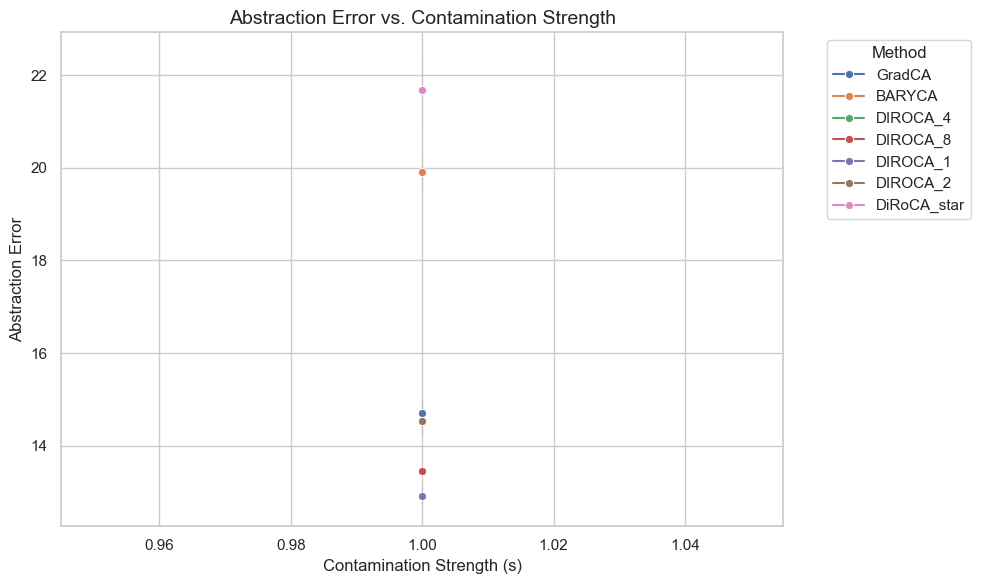

In [72]:
# Compile results into a DataFrame
f_spec_df = pd.DataFrame(f_spec_records)

print("\n--- F-Misspecification Evaluation Complete ---")
print("="*65)
print("Overall Performance (Averaged Across All Nonlinearity Strengths)")
print("="*65)
print(f"{'Method/Run':<35} | {'Mean ± Std'}")
print("="*65)

summary = f_spec_df.groupby('method')['error'].agg(['mean', 'std', 'count'])
summary['sem'] = summary['std']  # You can uncomment next line for CI
# summary['sem'] = summary['std'] / np.sqrt(summary['count'])
summary['ci95'] = summary['sem']  # or 1.96 * sem

for method_name, row in summary.sort_values('mean').iterrows():
    print(f"{method_name:<35} | {row['mean']:.4f} ± {row['ci95']:.4f}")

# Set plot style
sns.set(style="whitegrid")

# Plot abstraction error vs. contamination strength
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=f_spec_df,
    x="contamination",
    y="error",
    hue="method",
    estimator="mean",
    ci="sd",
    marker="o"
)

plt.title("Abstraction Error vs. Contamination Strength", fontsize=14)
plt.xlabel("Contamination Strength (s)", fontsize=12)
plt.ylabel("Abstraction Error", fontsize=12)
plt.legend(title="Method", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# Statistical Analysis: Paired t-tests for contamination analysis
from scipy.stats import ttest_rel
import warnings
warnings.filterwarnings('ignore')

def perform_contamination_tests(df, contamination_strength=None, alpha_level=0.05):
    """
    Perform paired t-tests for contamination analysis results.
    
    Parameters:
    - df: DataFrame with columns ['method', 'contamination', 'error', 'trial', 'fold']
    - contamination_strength: specific strength to test (if None, tests all)
    - alpha_level: significance level (default 0.05)
    """
    
    if contamination_strength is not None:
        df_filtered = df[df['contamination'] == contamination_strength].copy()
        print(f"\nSTATISTICAL ANALYSIS: Contamination Strength = {contamination_strength}")
    else:
        df_filtered = df.copy()
        print(f"\nSTATISTICAL ANALYSIS: All Contamination Strengths")
    
    if df_filtered.empty:
        print("No data available for the specified contamination strength.")
        return
    
    # Get summary statistics
    summary_stats = df_filtered.groupby(['method'])['error'].agg(['mean', 'std', 'count'])
    summary_stats['sem'] = summary_stats['std'] / np.sqrt(summary_stats['count'])
    
    # Find the best method (lowest mean error)
    best_method = summary_stats['mean'].idxmin()
    best_mean = summary_stats.loc[best_method, 'mean']
    
    print(f"Best performing method: {best_method}")
    print(f"Best method mean error: {best_mean:.4f}")
    print("\n" + "="*80)
    
    # Get all other methods
    other_methods = [method for method in summary_stats.index if method != best_method]
    
    print(f"{'Comparison':<50} | {'p-value':<10} | {'Significant':<12} | {'Effect Size'}")
    print("="*80)
    
    # Get data for best method
    best_data = df_filtered[df_filtered['method'] == best_method]['error'].values
    
    # Compare against all other methods
    for other_method in other_methods:
        other_data = df_filtered[df_filtered['method'] == other_method]['error'].values
        
        # Ensure same number of observations for paired test
        min_len = min(len(best_data), len(other_data))
        if min_len > 0:
            t_stat, p_value = ttest_rel(best_data[:min_len], other_data[:min_len])
            other_mean = summary_stats.loc[other_method, 'mean']
            diff = best_mean - other_mean
            
            # Calculate effect size (Cohen's d for paired samples)
            diff_array = best_data[:min_len] - other_data[:min_len]
            effect_size = np.mean(diff_array) / np.std(diff_array, ddof=1) if np.std(diff_array, ddof=1) > 0 else 0
            
            print(f"{best_method} vs {other_method:<35} | {p_value:<10.4f} | {'Yes' if p_value < alpha_level else 'No':<12} | {effect_size:>8.3f}")
        else:
            print(f"{best_method} vs {other_method:<35} | No data available")

# Test at specific contamination strength (e.g., strength = 10)
if not f_spec_df.empty:
    print("Testing at contamination strength = 10:")
    perform_contamination_tests(f_spec_df, contamination_strength=10.0)
    
    print("\n" + "="*80)
    print("Testing across all contamination strengths:")
    perform_contamination_tests(f_spec_df, contamination_strength=None)
else:
    print("No contamination analysis data available.")


Testing at contamination strength = 10:

STATISTICAL ANALYSIS: Contamination Strength = 10.0
No data available for the specified contamination strength.

Testing across all contamination strengths:

STATISTICAL ANALYSIS: All Contamination Strengths
Best performing method: DiRoCA_star
Best method mean error: 0.8888

Comparison                                         | p-value    | Significant  | Effect Size
DiRoCA_star vs BARYCA                              | 0.0000     | Yes          |   -1.244
DiRoCA_star vs DIROCA_1                            | 0.0000     | Yes          |   -1.902
DiRoCA_star vs DIROCA_2                            | 0.0000     | Yes          |   -1.487
DiRoCA_star vs DIROCA_4                            | 0.0000     | Yes          |   -1.934
DiRoCA_star vs DIROCA_8                            | 0.0000     | Yes          |   -1.934
DiRoCA_star vs GradCA                              | 0.0000     | Yes          |   -1.822



SPECIFIC METHOD COMPARISONS

Comparing DiRoCA_star vs GradCA at contamination strength = 10.0
No data available for the specified methods.

--------------------------------------------------

Comparing BARYCA vs DIROCA_2 at contamination strength = 10.0
No data available for the specified methods.

--------------------------------------------------

Comparing DiRoCA_star vs GradCA across all contamination strengths
Method 1 (DiRoCA_star): mean = 0.8888
Method 2 (GradCA): mean = 2.8407
Difference: -1.9519
p-value: 0.0000
Effect size: -1.822
Significant: Yes
